# Basis Expansion in Linear Regression

Nipun Batra, R Yeeshu Dhurandhar, Kalash Kankaria, Inderjeet Singh
Bhullar  
2024-01-22

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
# Interactive widget
from ipywidgets import interact


# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [41]:
# Download CO2 data from NOAA
url = 'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv'

names = 'year,month,decimal date,average,deseasonalized,ndays,sdev,unc'.split(',')

# no index
df = pd.read_csv(url, skiprows=72, names=names, index_col=False)

In [42]:
df

766 rows × 8 columns

In [43]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

Text(0, 0.5, 'CO2 Level')

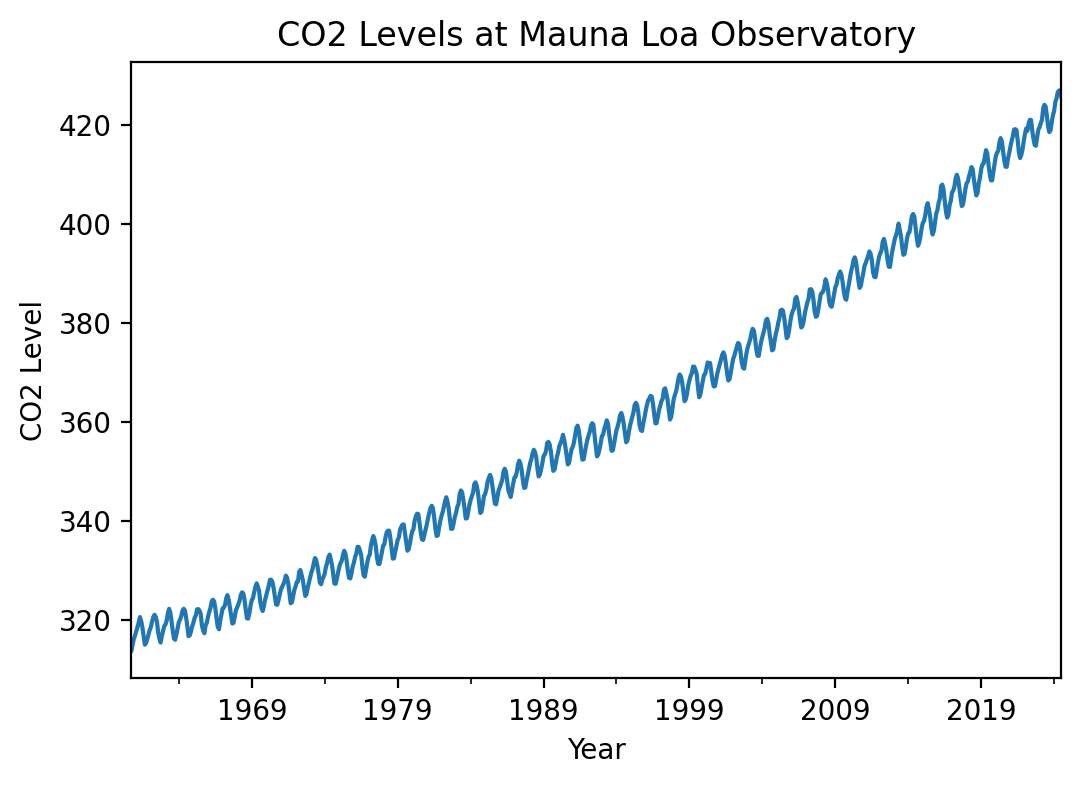

In [44]:
df.average.plot(figsize=(6, 4), title='CO2 Levels at Mauna Loa Observatory')
plt.xlabel('Year')
plt.ylabel('CO2 Level')

In [45]:
# Create X and y

# X = months since first measurement
X = np.array(range(len(df)))
y = df.average.values

Text(0, 0.5, 'CO2 Level')

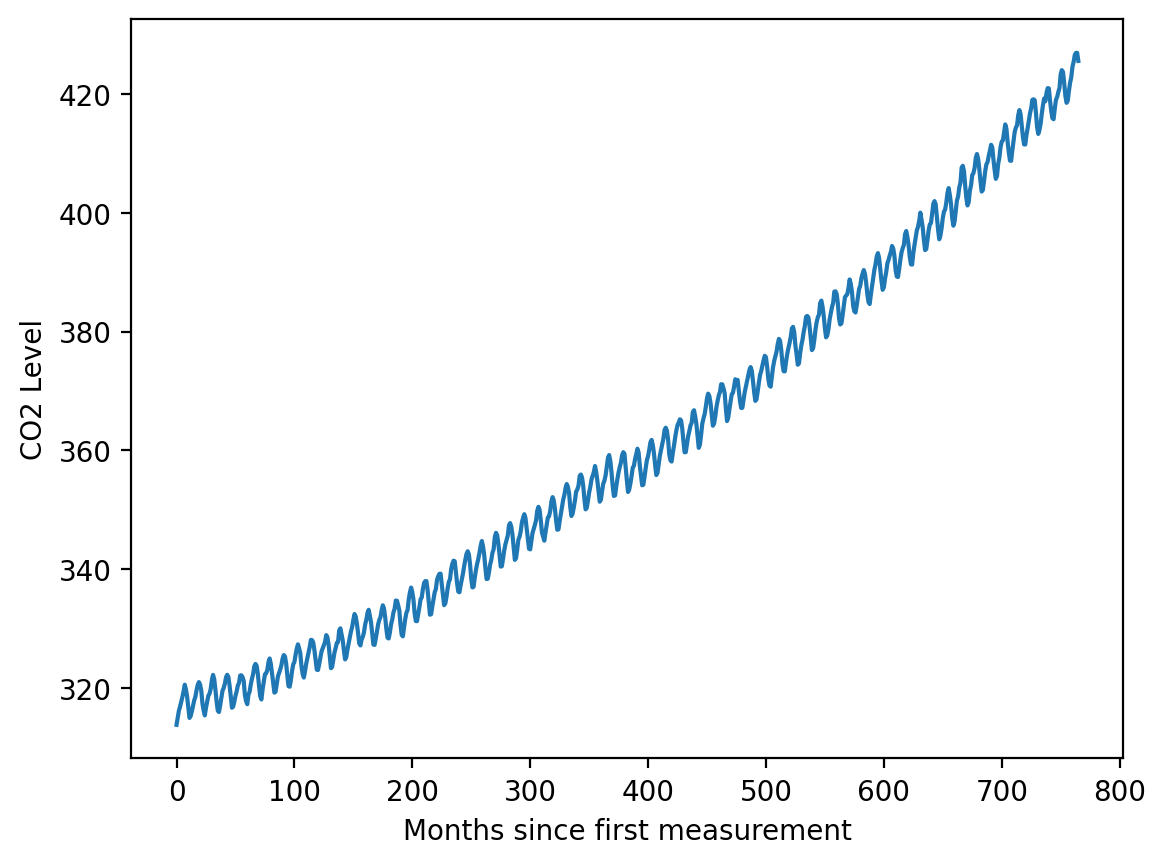

In [46]:
plt.plot(X, y)
plt.xlabel('Months since first measurement')
plt.ylabel('CO2 Level')

In [8]:
# Normalize X and y

s1 = StandardScaler()
s2 = StandardScaler()

X_norm = s1.fit_transform(X.reshape(-1, 1))
y_norm = s2.fit_transform(y.reshape(-1, 1))

In [9]:
X_norm.mean(), X_norm.std()

(0.0, 0.9999999999999999)

In [48]:
df = pd.DataFrame({"x":X.flatten(), "transformed":X_norm.flatten()})
df

766 rows × 2 columns

In [49]:
df["re-transformed"] = s1.inverse_transform(df["transformed"].values.reshape(-1, 1))
df

766 rows × 3 columns

In [50]:
df.mean()

x                 382.5
transformed         0.0
re-transformed    382.5
dtype: float64

In [51]:
df.std()

x                 221.269444
transformed         1.000653
re-transformed    221.269444
dtype: float64

In [52]:
x_test = np.array([800])
s1.transform(x_test.reshape(-1, 1))

array([[1.88807266]])

In [53]:
y_norm.mean(), y_norm.std()

(-2.003619202665557e-15, 0.9999999999999998)

Text(0, 0.5, '(Normalized) CO2 Level')

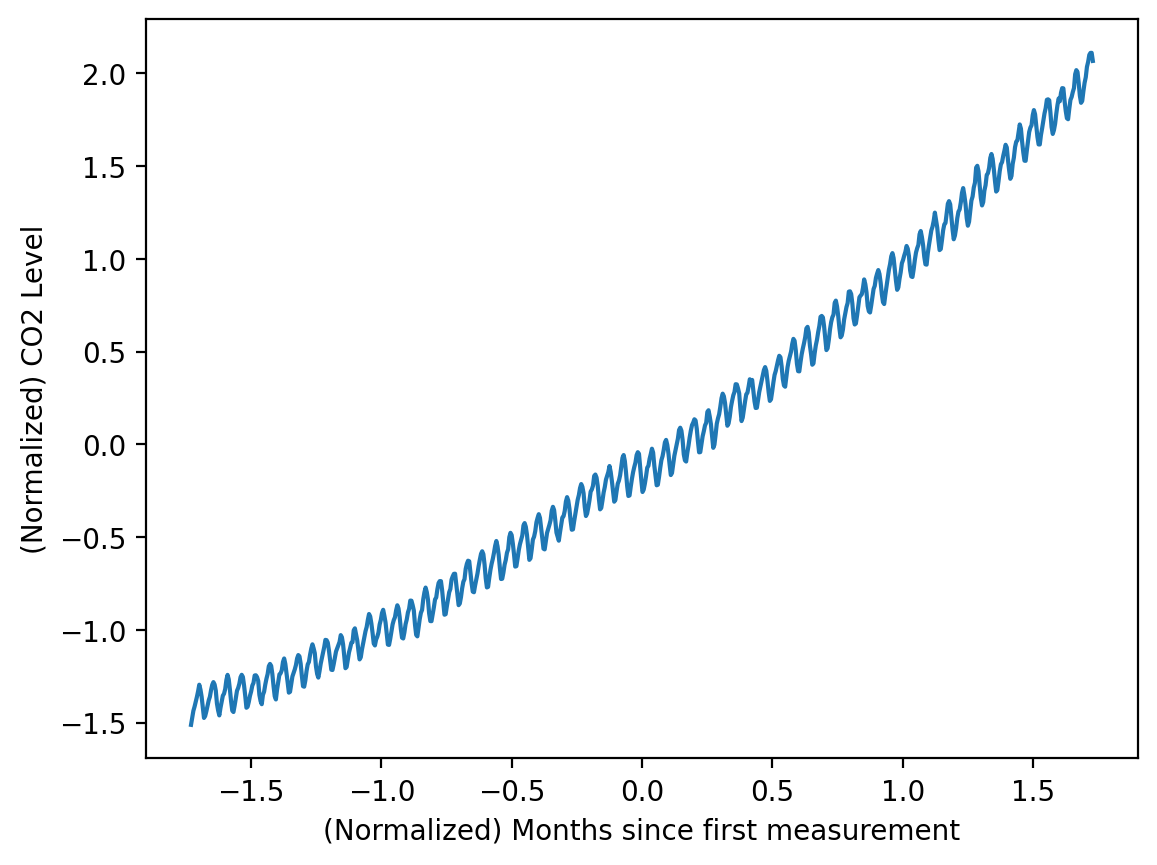

In [54]:
plt.plot(X_norm, y_norm)
plt.xlabel('(Normalized) Months since first measurement')
plt.ylabel('(Normalized) CO2 Level')

#### Task 1: Interpolation

In [55]:
np.random.seed(42)
train_idx = np.random.choice(range(len(X_norm)), size=int(len(X_norm) * 0.7), replace=False)
test_idx = list(set(range(len(X_norm))) - set(train_idx))

X_train = X[train_idx]
y_train = y[train_idx]

X_test = X[test_idx]
y_test = y[test_idx]

X_norm_train = X_norm[train_idx]
y_norm_train = y_norm[train_idx]

X_norm_test = X_norm[test_idx]
y_norm_test = y_norm[test_idx]

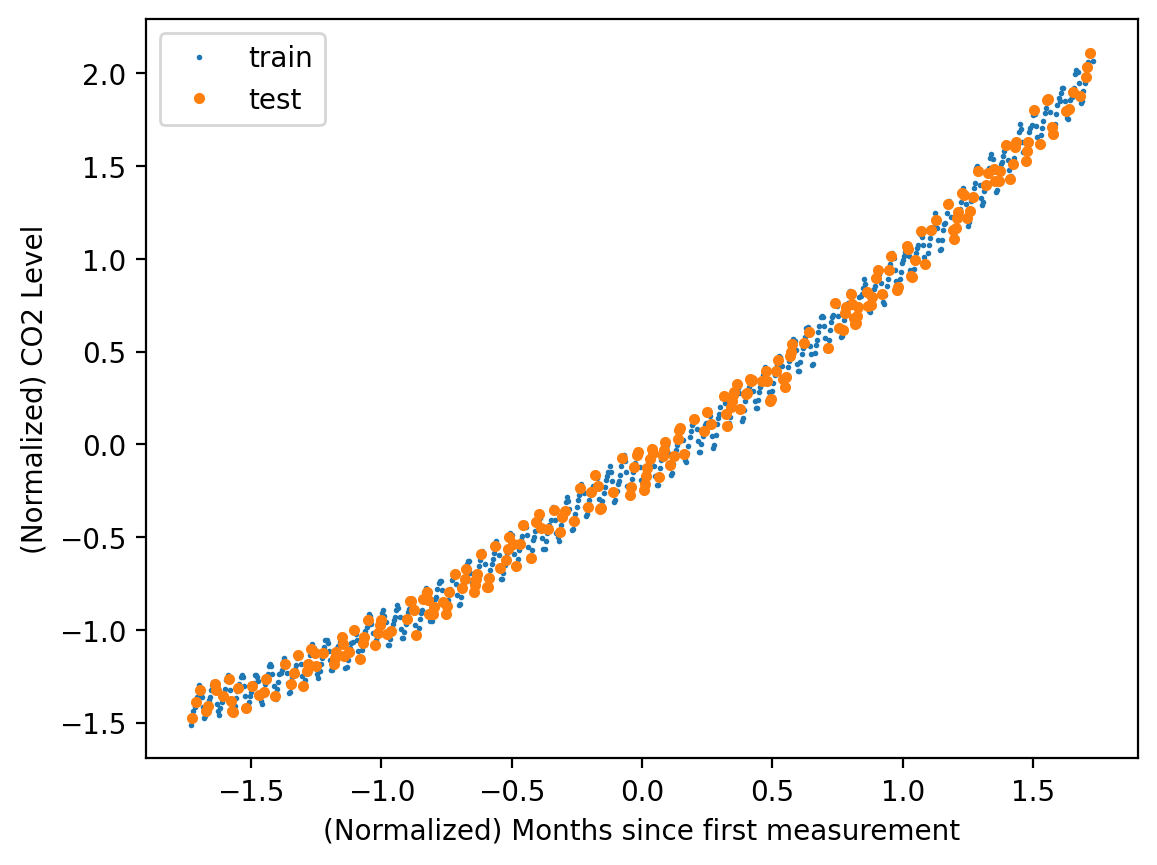

In [56]:
plt.plot(X_norm_train, y_norm_train, 'o', label='train',markersize=1)
plt.plot(X_norm_test, y_norm_test, 'o', label='test', ms=3)
plt.xlabel('(Normalized) Months since first measurement')
plt.ylabel('(Normalized) CO2 Level')
plt.legend()

In [19]:
errors= {}
X_lin_1d = np.linspace(X_norm.min(), X_norm.max(), 100).reshape(-1, 1)

### Model 1: Vanilla Linear Regression

In [57]:
def plot_fit_predict(model, X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin, title, plot=True):
    model.fit(X_norm_train, y_norm_train)

    y_hat_train = model.predict(X_norm_train).reshape(-1, 1)
    y_hat_test = model.predict(X_norm_test).reshape(-1, 1)

    # Transform back to original scale
    y_hat_train = s2.inverse_transform(y_hat_train)
    y_hat_test = s2.inverse_transform(y_hat_test)

    y_hat_lin = s2.inverse_transform(model.predict(X_lin).reshape(-1, 1))

    errors[title] = {"train": mean_squared_error(y_train, y_hat_train),
                     "test": mean_squared_error(y_test, y_hat_test)}

    if plot:
        plt.plot(X_train, y_train, 'o', label='train', markersize=1)
        plt.plot(X_test, y_test, 'o', label='test', ms=3)
        plt.plot(s1.inverse_transform(X_lin_1d), y_hat_lin, label='model')
        plt.xlabel('Months since first measurement')
        plt.ylabel('CO2 Levels')
        plt.legend()
        plt.title('{}\n Train MSE: {:.2f} | Test MSE: {:.2f}'.format(title, errors[title]["train"], errors[title]["test"]))

    return errors[title]

{'train': 22.02534268790436, 'test': 18.72254862852729}

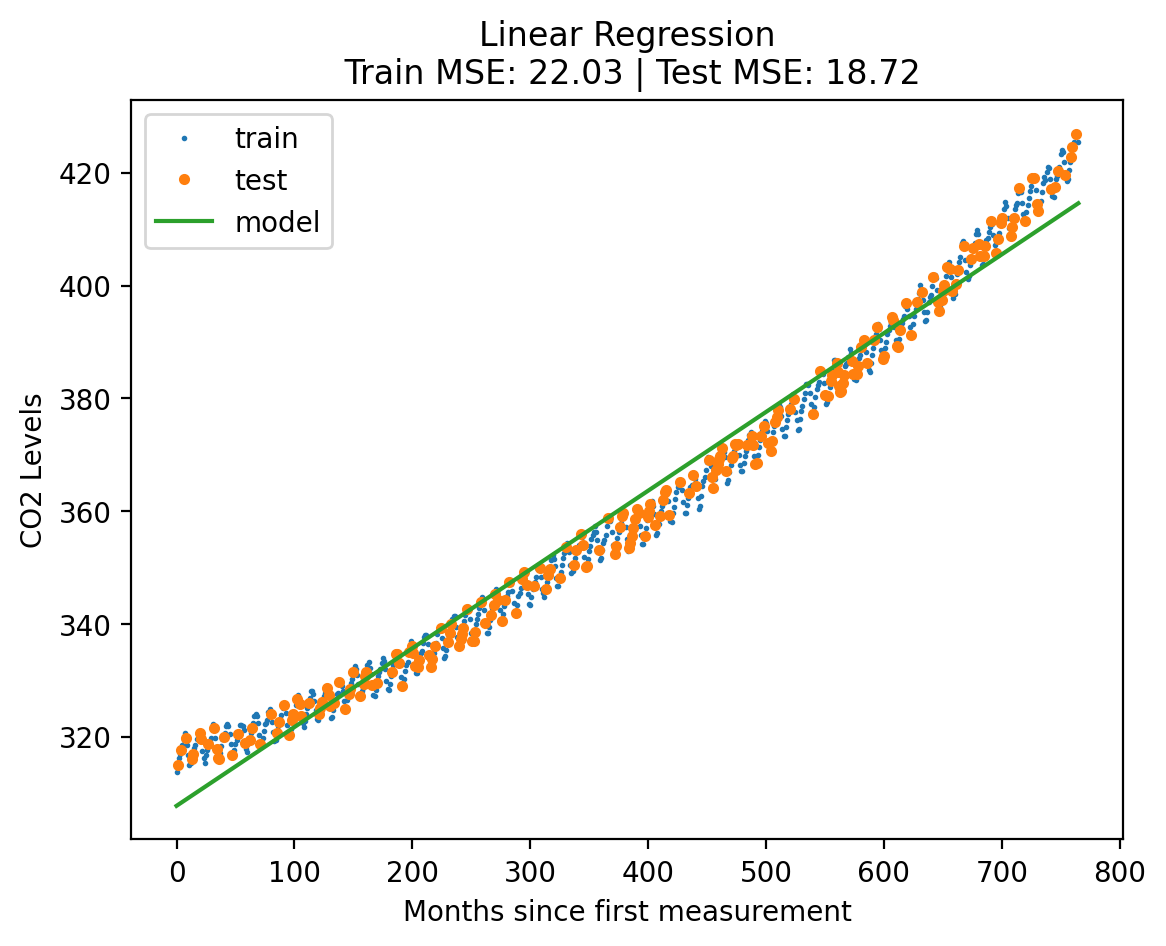

In [58]:
model = LinearRegression()
plot_fit_predict(model, X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin_1d, "Linear Regression")

### MLP

{'train': 5.935971669202183, 'test': 6.511128786459153}

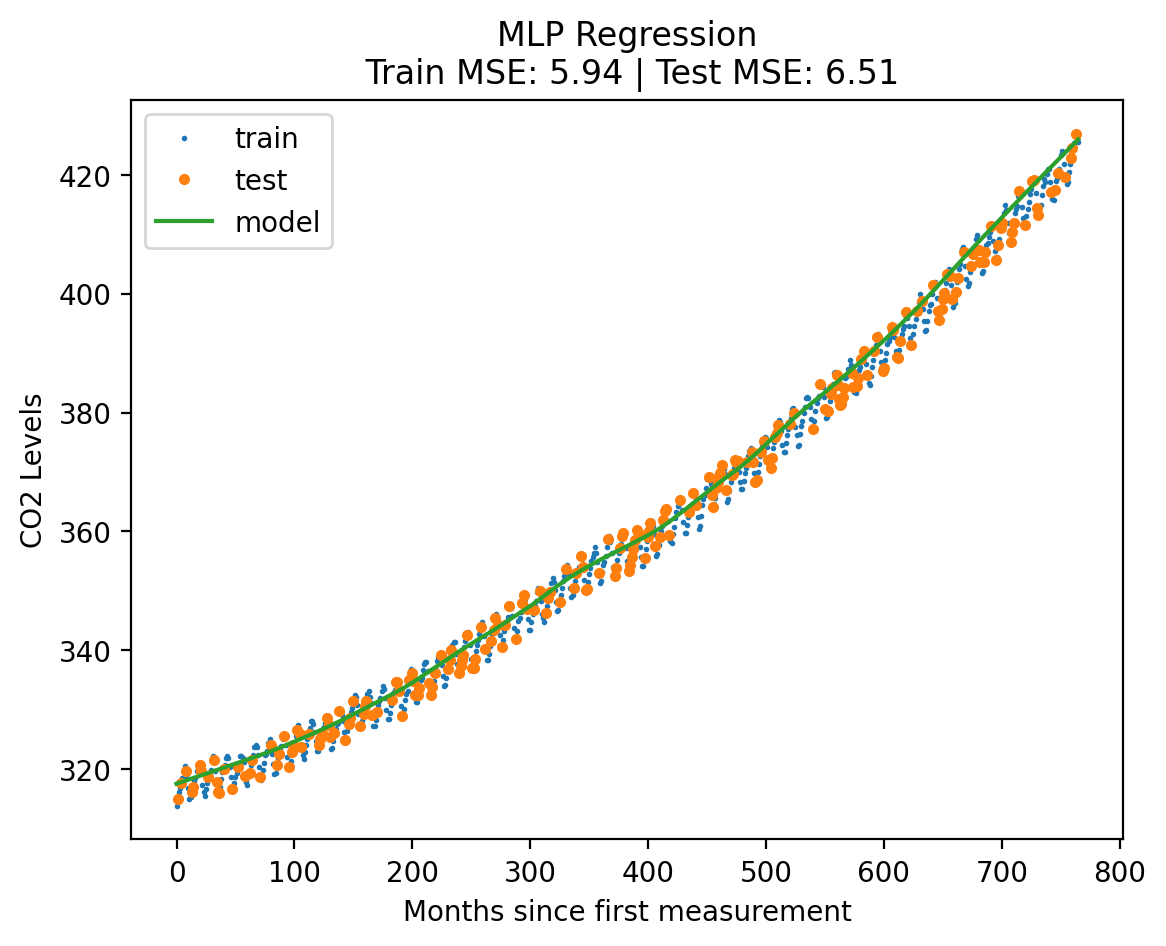

In [59]:
# use sk-learn for MLP
mlp_model = MLPRegressor(hidden_layer_sizes=[128, 256, 512, 256, 128], max_iter = 10000)

plot_fit_predict(mlp_model, X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin_1d, "MLP Regression")

### Polynomial Regression of degree “d”

In [60]:
def create_poly_features(X, d):
    """
    X is (N, 1) array
    d is degree of polynomial
    returns normalized polynomial features of X
    """
    
    X_poly = np.zeros((len(X), d))
    X_poly[:, 0] = X[:, 0]
    for i in range(1, d):
        X_poly[:, i] = X[:, 0] ** (i + 1)
    
    # Normalize each column
    X_poly = StandardScaler().fit_transform(X_poly)
    return X_poly

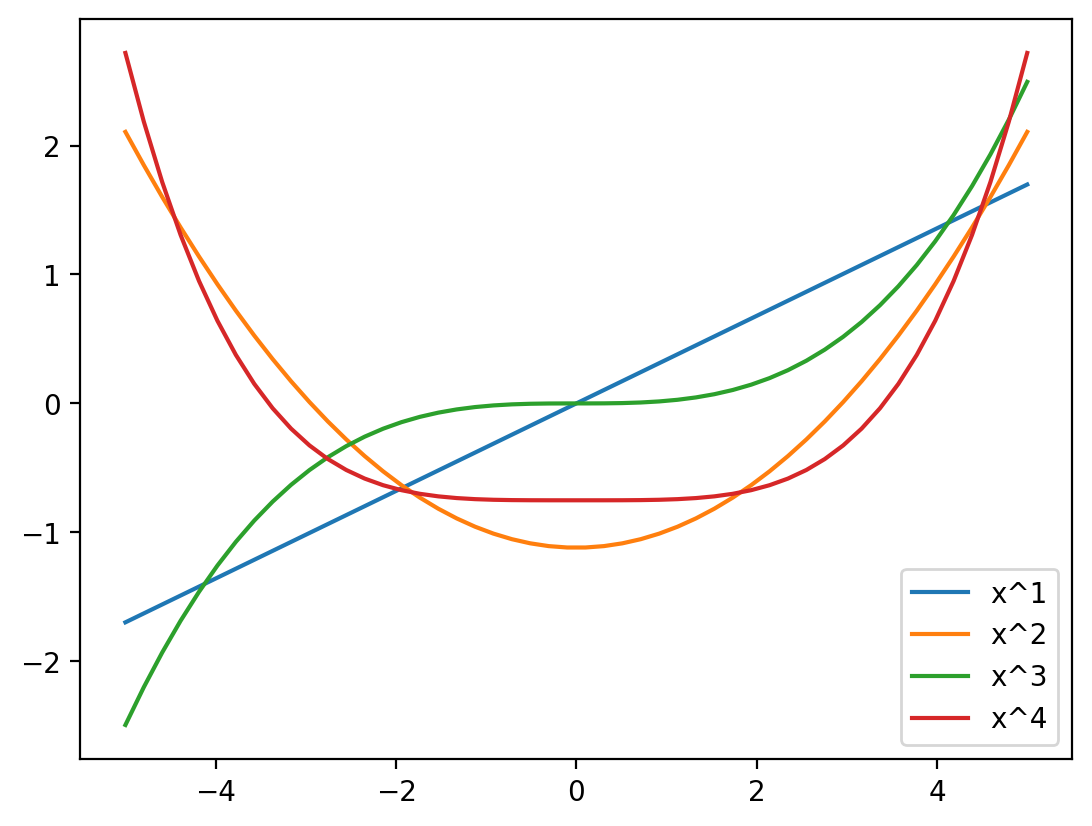

In [67]:
xs = np.linspace(-5, 5, 50).reshape(-1, 1)
poly_f = create_poly_features(xs, 4)
for i in range(4):
    plt.plot(xs, poly_f[:, i], label='x^{}'.format(i+1))
plt.legend()

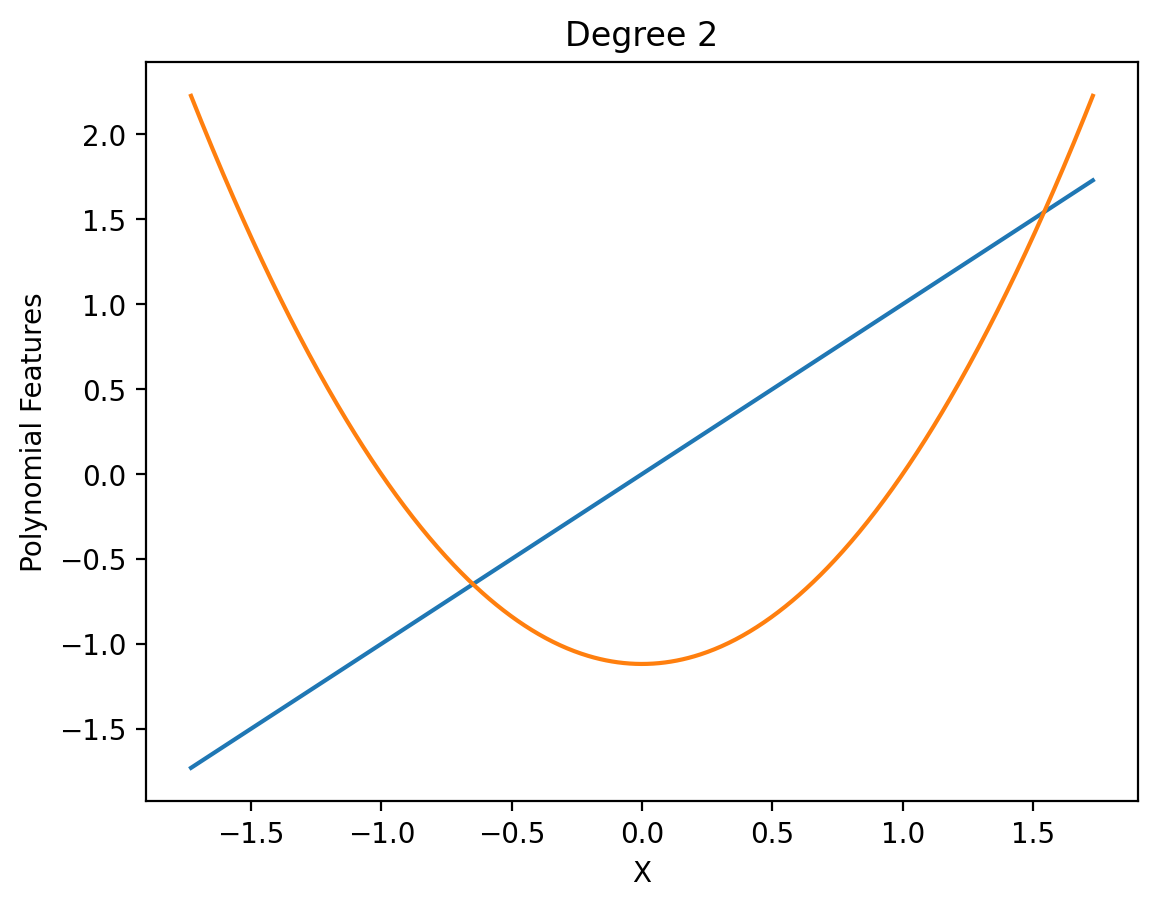

In [62]:
def show_poly_features(degree):
    X_poly = create_poly_features(X_norm, degree)
    plt.plot(X_norm, X_poly)
    plt.xlabel('X')
    plt.ylabel('Polynomial Features')
    plt.title('Degree {}'.format(degree))

show_poly_features(2)

In [63]:
interact(show_poly_features, degree=(1, 10, 1))

<function __main__.show_poly_features(degree)>

{'train': 4.911310087864347, 'test': 6.6713097074692875}

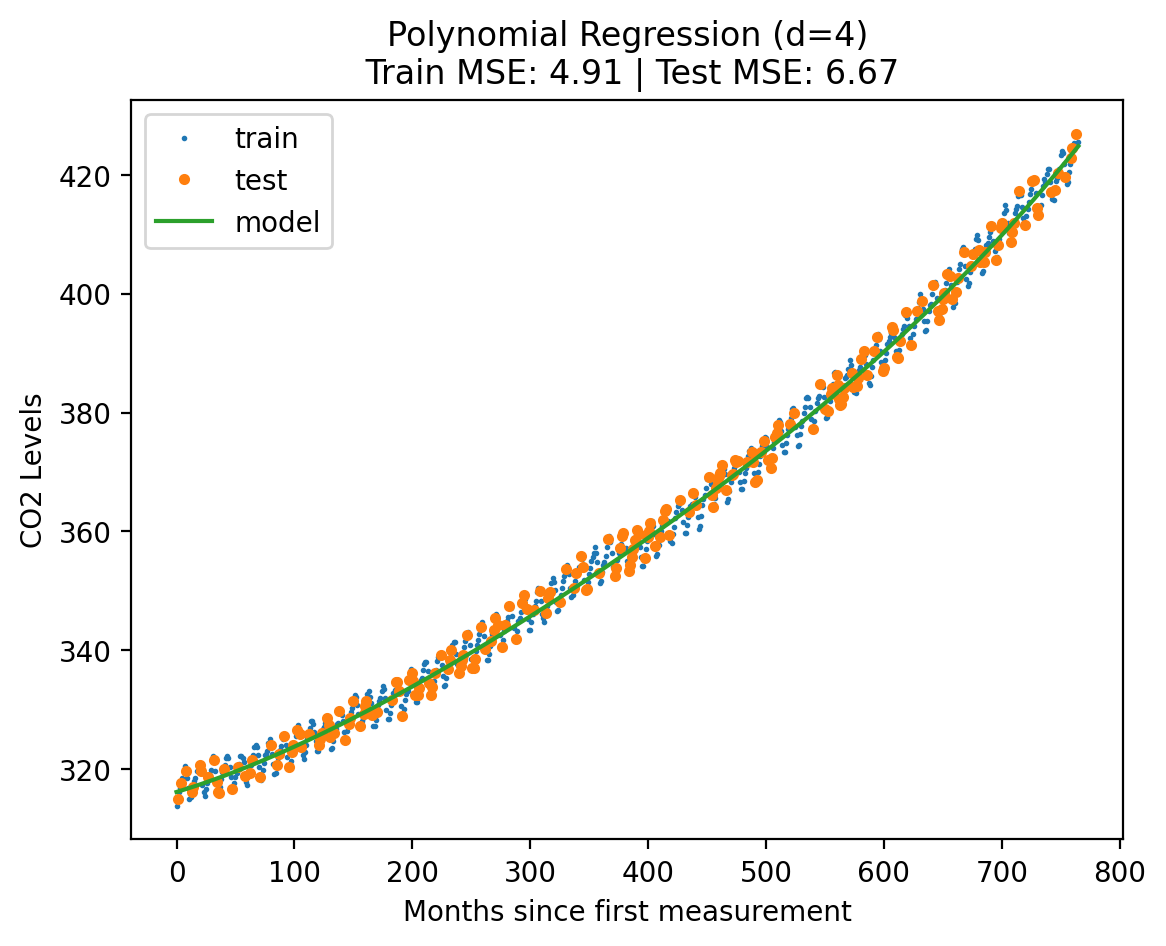

In [64]:
model2 = LinearRegression()
degree = 4
Xf_norm_train = create_poly_features(X_norm_train.reshape(-1, 1), degree)
Xf_norm_test = create_poly_features(X_norm_test.reshape(-1, 1), degree)
X_lin_poly = create_poly_features(X_lin_1d, degree)

plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Polynomial Regression (d={degree})")

In [65]:
model2.coef_, model2.intercept_

(array([[0.97361847, 0.09894695, 0.02772375, 0.03416679]]),
 array([-0.00901074]))

In [29]:
X_lin_poly.shape

(100, 4)

In [30]:
X_lin_poly.shape

(100, 4)

In [31]:
model2.coef_.shape

(1, 4)

In [32]:
X_lin_1d.shape

(100, 1)

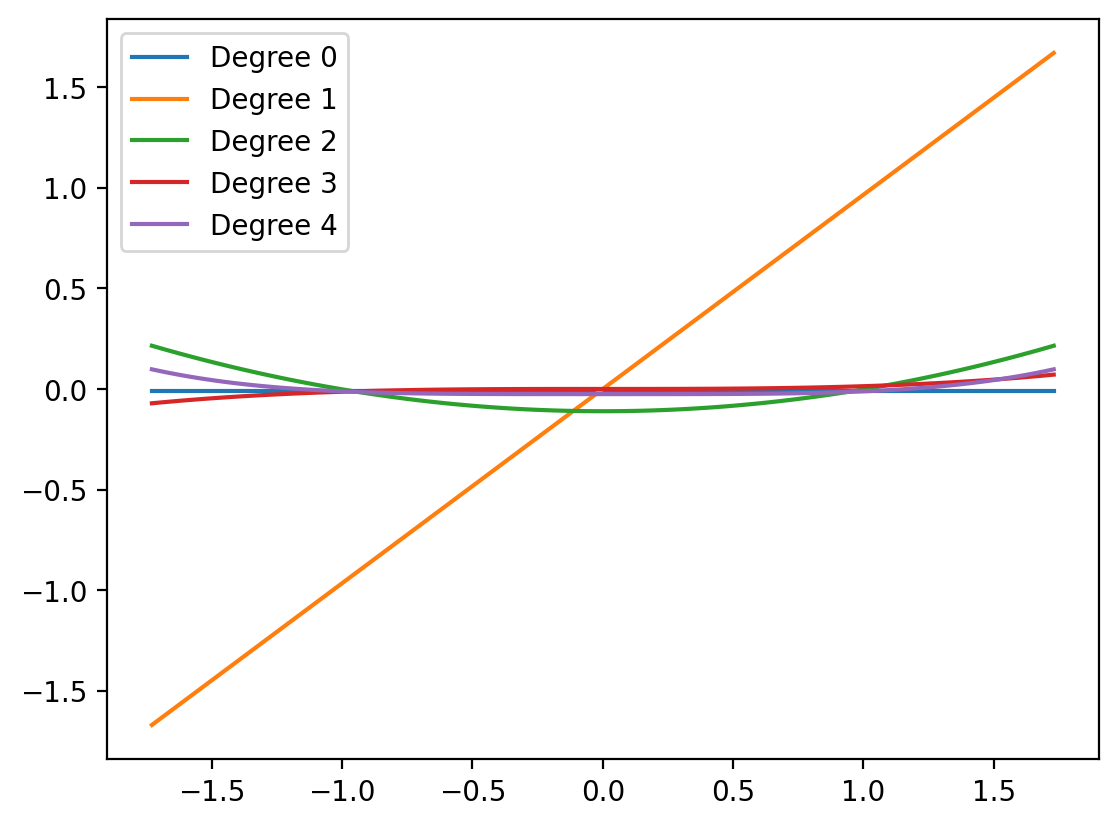

In [68]:
plt.plot(X_lin_1d, model2.intercept_.repeat(len(X_lin_1d)), label='Degree 0')
plt.plot(X_lin_1d, X_lin_poly[:, 0:1]@model2.coef_[:, 0], label='Degree 1')
plt.plot(X_lin_1d, X_lin_poly[:, 1:2]@model2.coef_[:, 1], label='Degree 2')
plt.plot(X_lin_1d, X_lin_poly[:, 2:3]@model2.coef_[:, 2], label='Degree 3')
plt.plot(X_lin_1d, X_lin_poly[:, 3:4]@model2.coef_[:, 3], label='Degree 4')
plt.legend()

(100,) (100, 1)

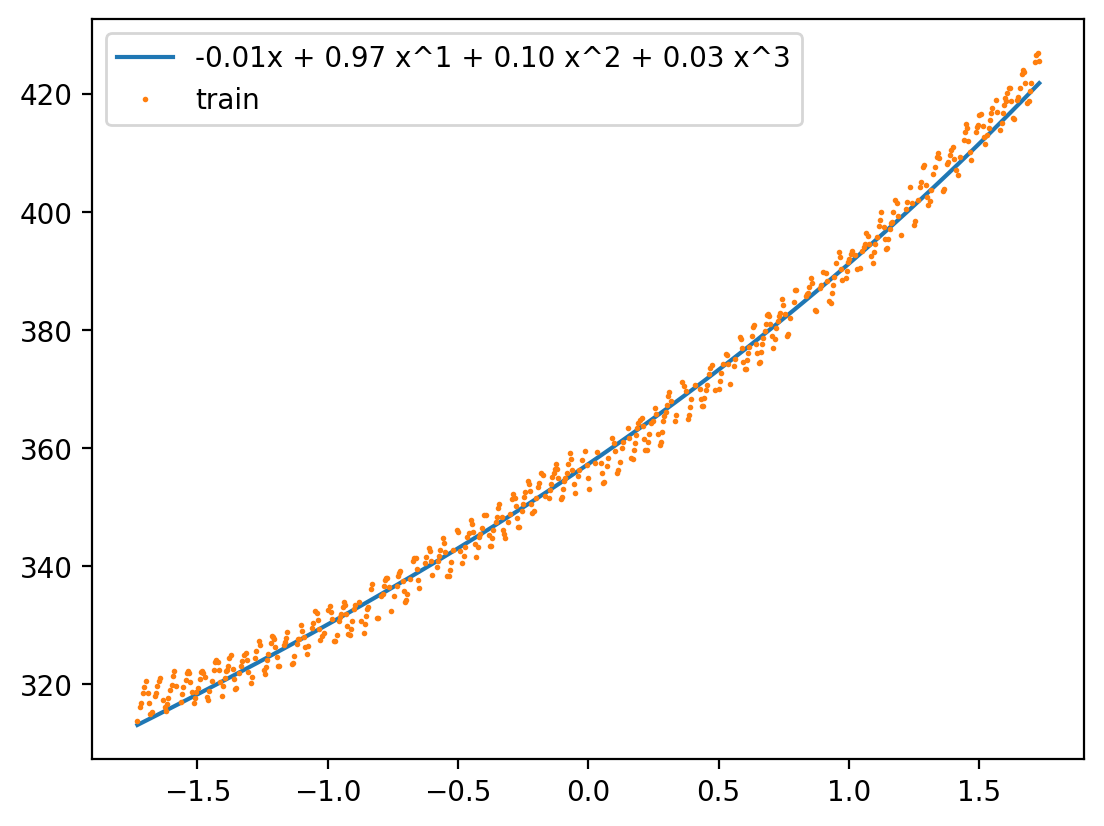

In [69]:
def show_additive(model, X_lin_1d, max_degree):
    ys = model.intercept_.repeat(len(X_lin_1d))
    #plt.fill_between(X_lin_1d.squeeze(), s2.inverse_transform(ys.reshape(-1, 1)).squeeze(), alpha=0.1)
    print(ys.shape, X_lin_1d.shape)
    label = '{:0.2f}x'.format(model.intercept_[0])
    
    for i in range(1, max_degree + 1):
        yd = X_lin_poly[:, i-1:i]@model.coef_[:, i-1]
        ys = ys + yd
        label += ' + {:0.2f} x^{}'.format(model.coef_[:, i-1][0], i)
    ys = s2.inverse_transform(ys.reshape(-1, 1))
    plt.plot(X_lin_1d, ys, label = label)
    plt.plot(X_norm_train, y_train, 'o', label='train', markersize=1)
    plt.legend()

show_additive(model2, X_lin_1d, 3)

In [70]:
from ipywidgets import interact, fixed
m = model2
interact(show_additive, model=fixed(m), X_lin_1d=fixed(X_lin_1d), max_degree=(1, len(m.coef_[0]), 1))

<function __main__.show_additive(model, X_lin_1d, max_degree)>

In [71]:
for degree in range(1, 10):
    Xf_norm_train = create_poly_features(X_norm_train.reshape(-1, 1), degree)
    Xf_norm_test = create_poly_features(X_norm_test.reshape(-1, 1), degree)

    X_lin_poly = create_poly_features(X_lin_1d, degree)

    plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Polynomial Regression (d={degree})", plot=False)

In [72]:
errors_df = pd.DataFrame(errors).T
errors_df

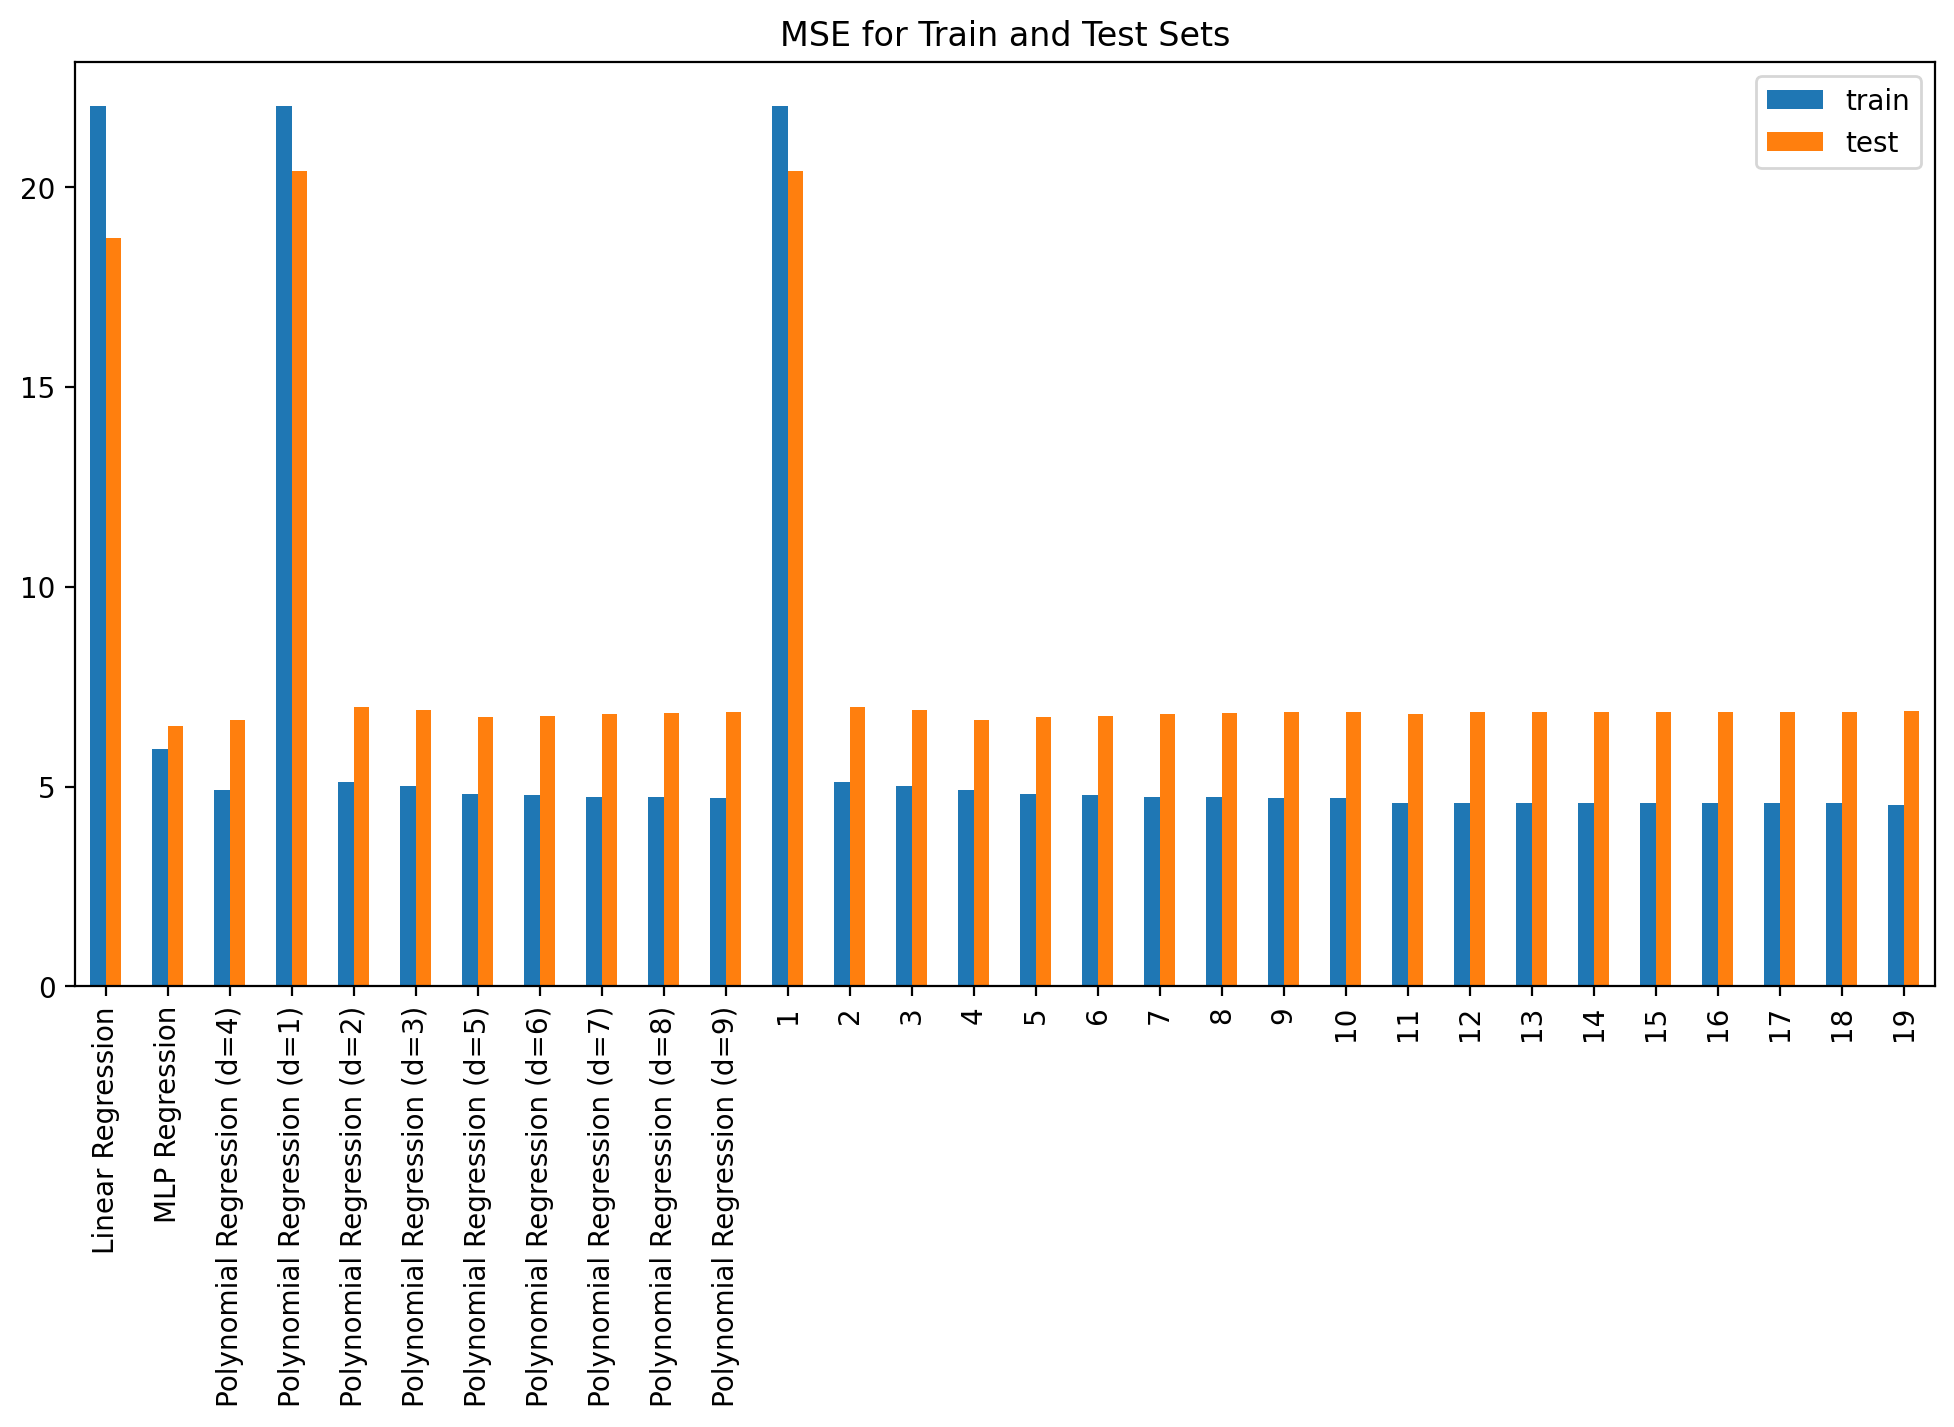

In [74]:
errors_df.plot(kind='bar', figsize=(12, 6), title='MSE for Train and Test Sets')

In [75]:
# bias variance tradeoff

errors_poly = {}

for degree in range(1, 20):
    Xf_norm_train = create_poly_features(X_norm_train.reshape(-1, 1), degree)
    Xf_norm_test = create_poly_features(X_norm_test.reshape(-1, 1), degree)

    X_lin_poly = create_poly_features(X_lin_1d, degree)

    plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, degree, plot=False)

    # geting errors for polynomial regression only for plotting
    errors_poly[degree] = errors[degree]

Best degree: 4, Min error: 6.904987394528579

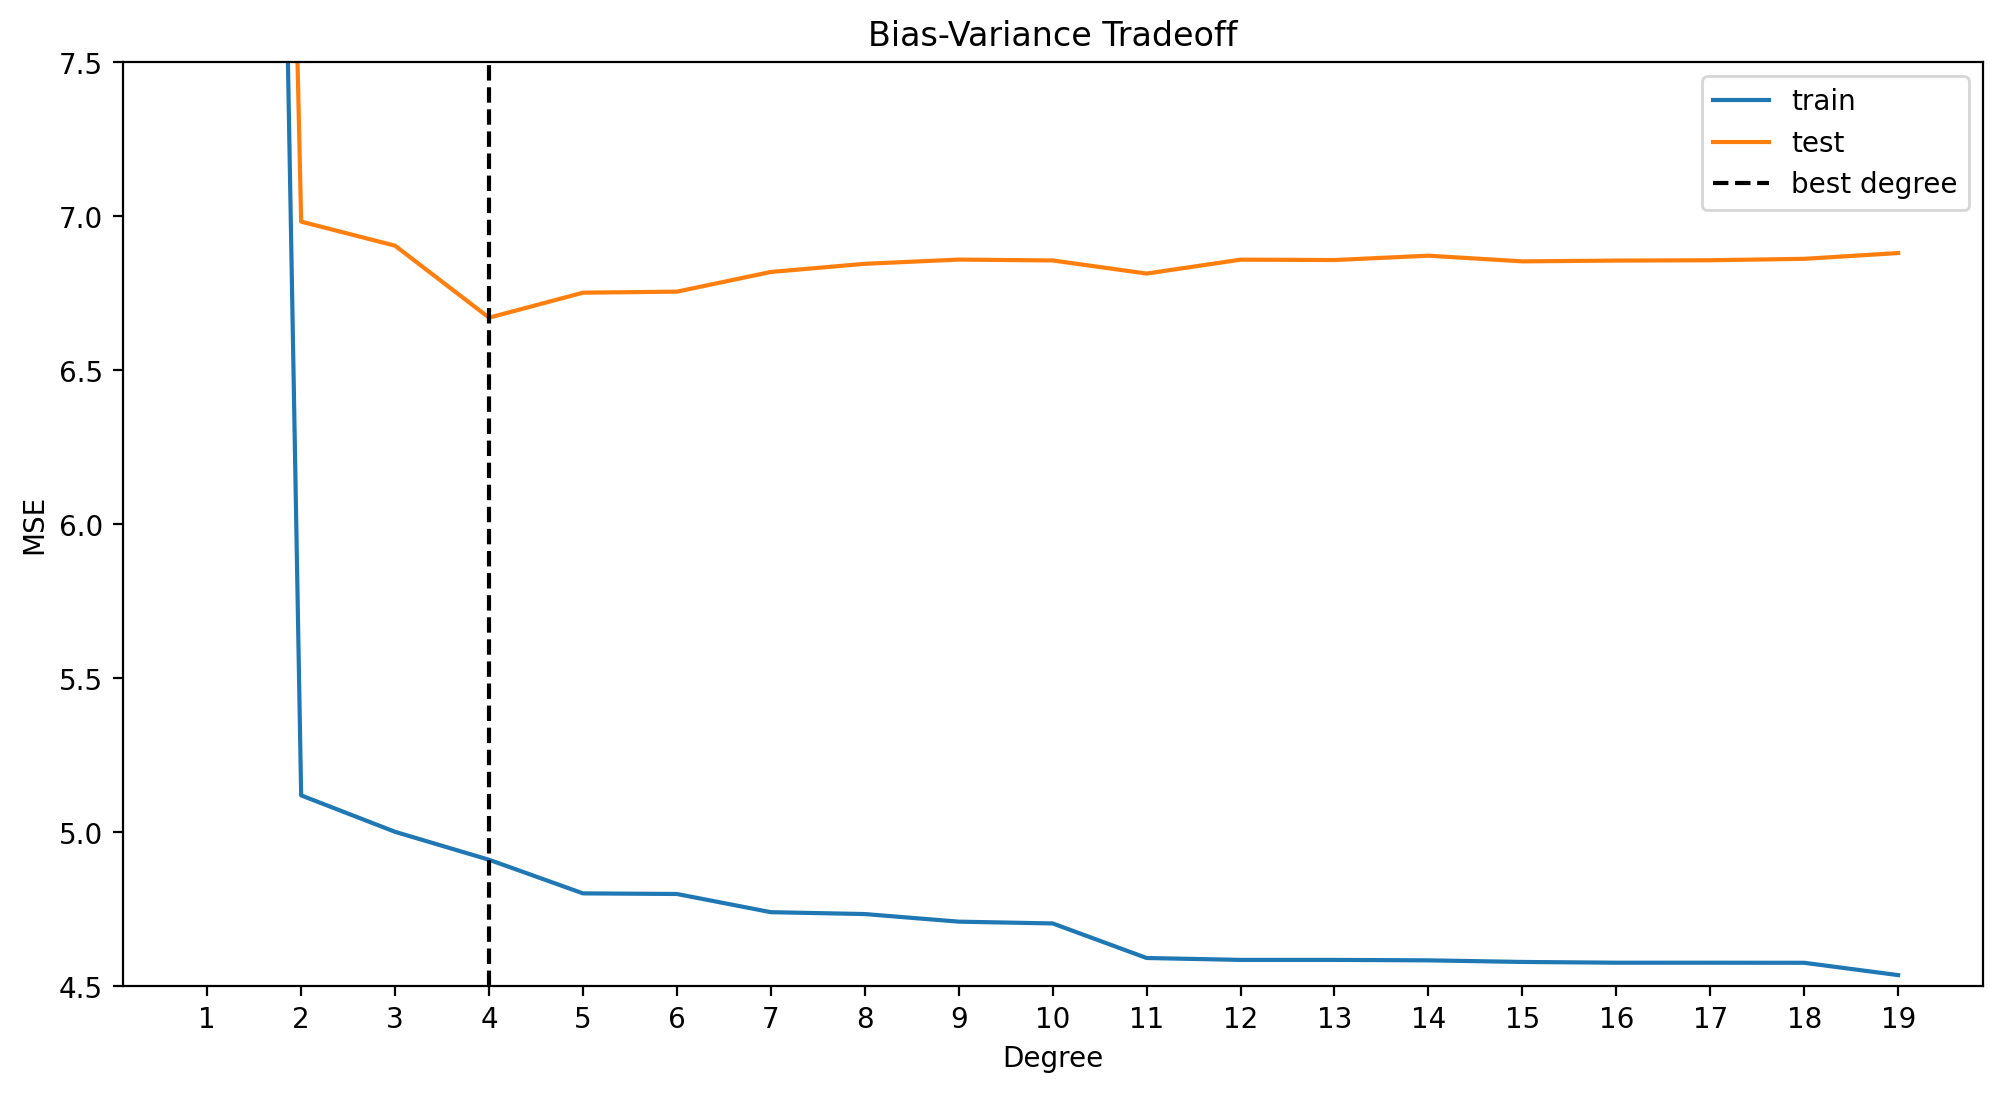

In [76]:
errors_poly_df = pd.DataFrame(errors_poly).T
best_degree = np.argmin(errors_poly_df.test) + 1
min_error = errors_poly_df.test[best_degree - 1]    # index of df = degree - 1
print(f"Best degree: {best_degree}, Min error: {min_error}")

# set figure size
plt.figure(figsize=(12, 6))
plt.plot(errors_poly_df.index.values, errors_poly_df.train.values, label='train')
plt.plot(errors_poly_df.index.values, errors_poly_df.test.values, label='test')
plt.axvline(best_degree, color='black', linestyle='--', label='best degree')
plt.xticks(np.arange(min(errors_poly_df.index), max(errors_poly_df.index)+1, 1.0))
plt.ylim(4.5, 7.5)      # set y limit - to show the difference between train and test clearly
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.show()

### Ridge Regression with polynomial basis

In [193]:
# initiate ridge regression model
model_ridge = Ridge(alpha=0.3)

errors_ridge = {}

for degree in range(1, 20):
    Xf_norm_train = create_poly_features(X_norm_train.reshape(-1, 1), degree)
    Xf_norm_test = create_poly_features(X_norm_test.reshape(-1, 1), degree)

    X_lin_poly = create_poly_features(X_lin_1d, degree)

    plot_fit_predict(model_ridge, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f'ridge_{degree}', plot=False)

    # geting errors for polynomial regression only for plotting
    errors_ridge[degree] = errors[f'ridge_{degree}']

Best degree: 4, Min error: 6.535907094411071

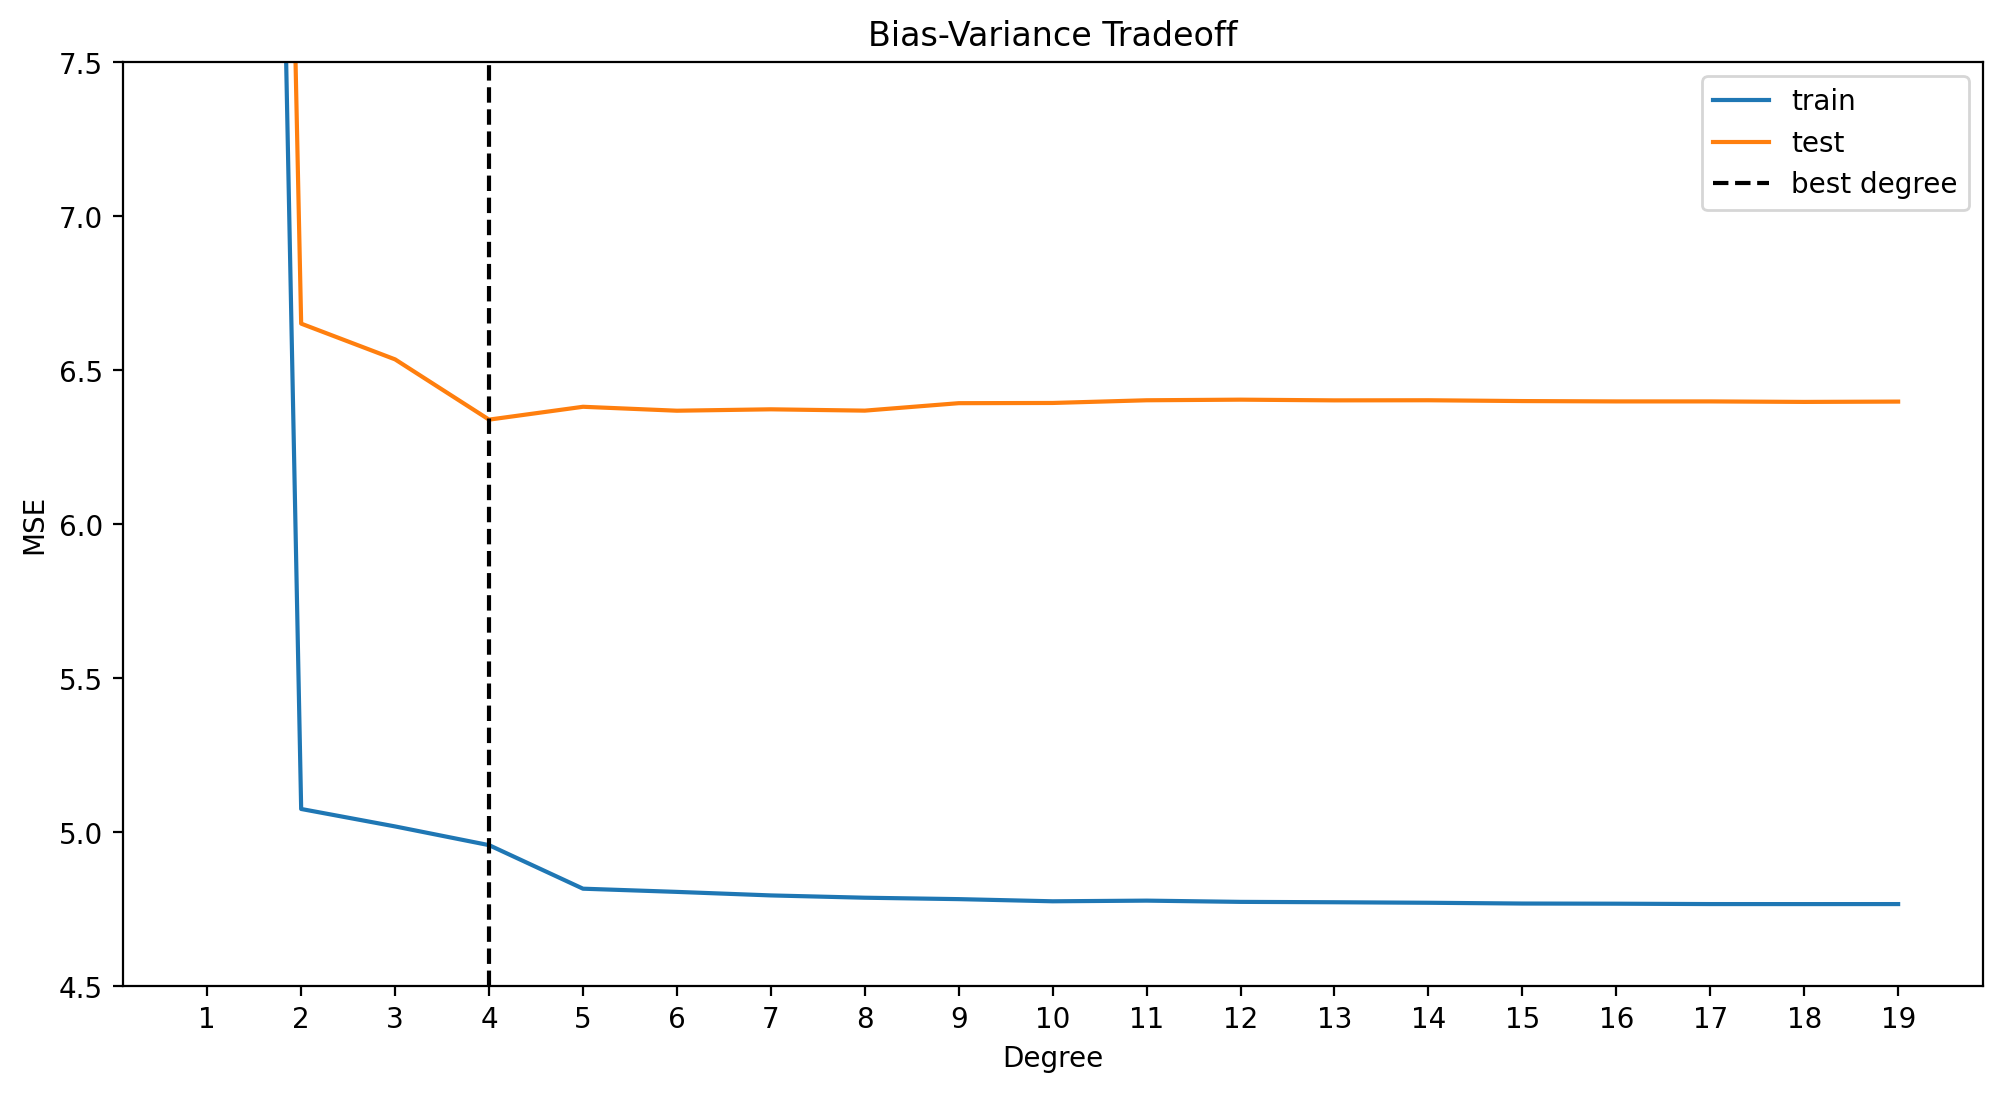

In [194]:
errors_ridge_df = pd.DataFrame(errors_ridge).T
best_degree_ridge = np.argmin(errors_ridge_df.test) + 1
min_error = errors_ridge_df.test[best_degree_ridge - 1]    # index of df = degree - 1
print(f"Best degree: {best_degree_ridge}, Min error: {min_error}")

# set figure size
plt.figure(figsize=(12, 6))
plt.plot(errors_ridge_df.index.values, errors_ridge_df.train.values, label='train')
plt.plot(errors_ridge_df.index.values, errors_ridge_df.test.values, label='test')
plt.axvline(best_degree_ridge, color='black', linestyle='--', label='best degree')
plt.xticks(np.arange(min(errors_ridge_df.index), max(errors_ridge_df.index)+1, 1.0))
plt.ylim(4.5, 7.5)      # set y limit - to show the difference between train and test clearly
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.show()

{'train': 4.767435271070607, 'test': 6.39886853568042}

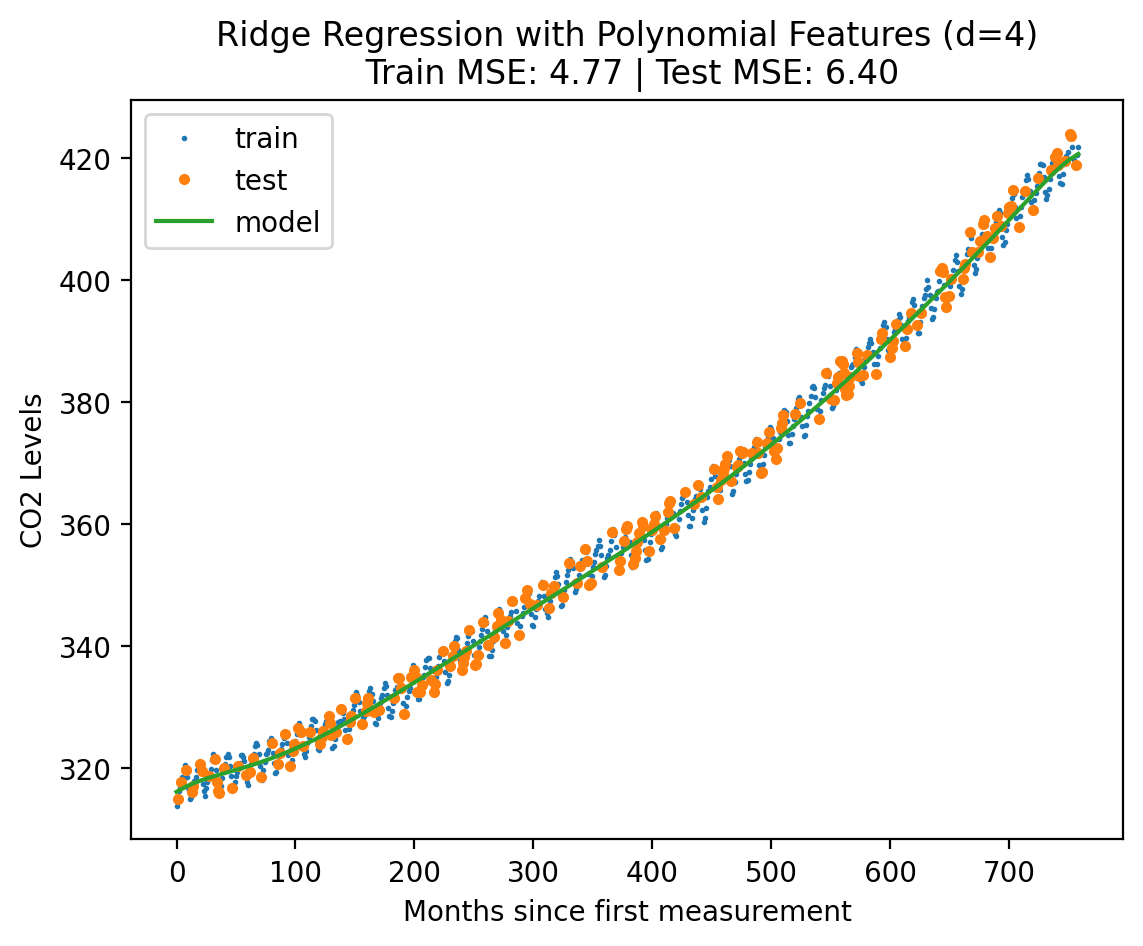

In [195]:
plot_fit_predict(model_ridge, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Ridge Regression with Polynomial Features (d={best_degree_ridge})", plot=True)

### Gausian Basis Function

In [77]:
def create_guassian_basis(X , d , std = 1):
    """
    X is (N, 1) array
    d is number of basis functions
    """
    means = np.linspace(X.min(), X.max(), d)
    X = np.repeat(X, d, axis=1)
    means = np.repeat(means.reshape(-1, 1), len(X), axis=1).T

    return np.exp(-(X - means) ** 2 / (2 * std ** 2))

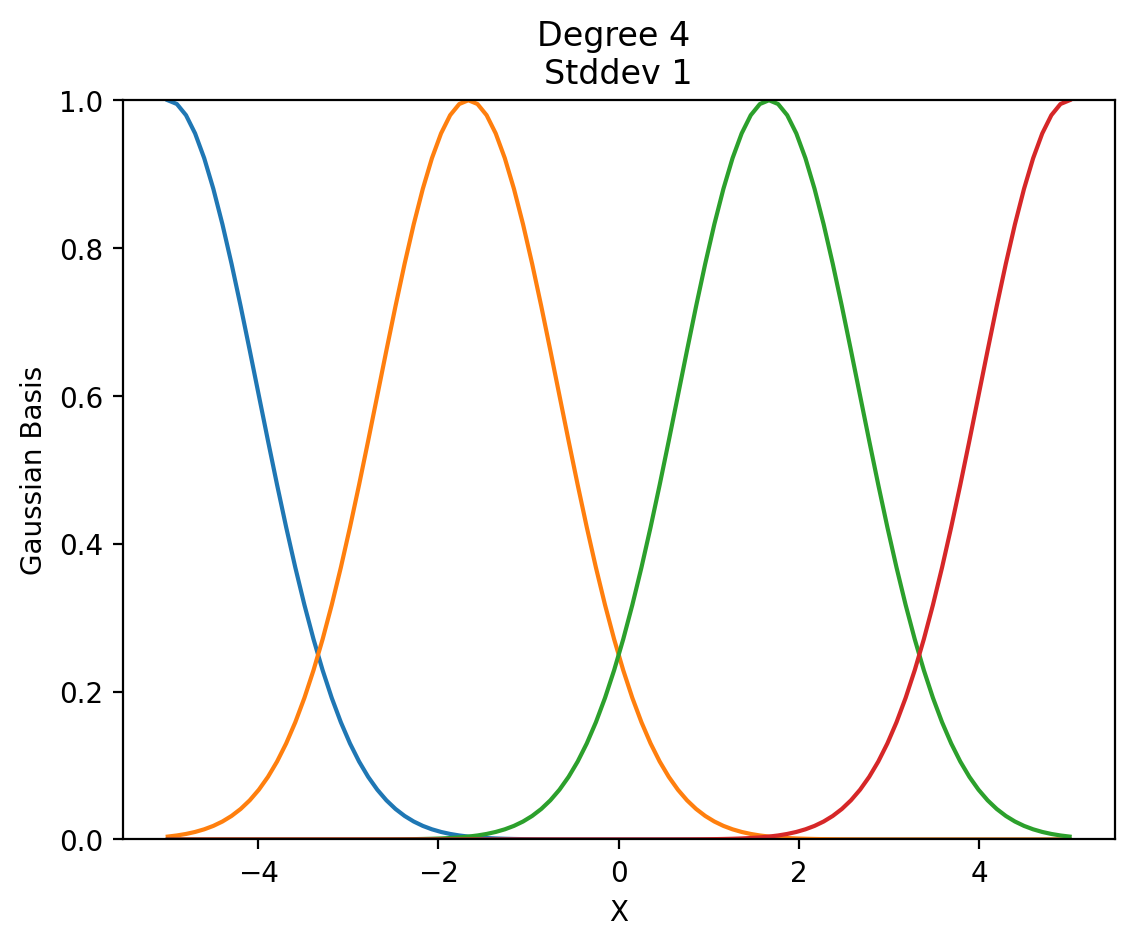

In [105]:
def show_gaussian_basis(d, stdev):
    xs = np.linspace(-5, 5, 100).reshape(-1, 1)
    X_gauss = create_guassian_basis(xs, d, std=stdev)
    plt.plot(xs, X_gauss)
    plt.xlabel('X')
    plt.ylabel('Gaussian Basis')
    plt.title('Degree {} \nStddev {}'.format(d, stdev))
    plt.ylim(0, 1)

show_gaussian_basis(4, 1)

In [106]:
interact(show_gaussian_basis, d=(1, 10, 1), stdev=(0.1, 20, 0.1))

<function __main__.show_gaussian_basis(d, stdev)>

{'train': 5.390651367676581, 'test': 5.618947635873222}

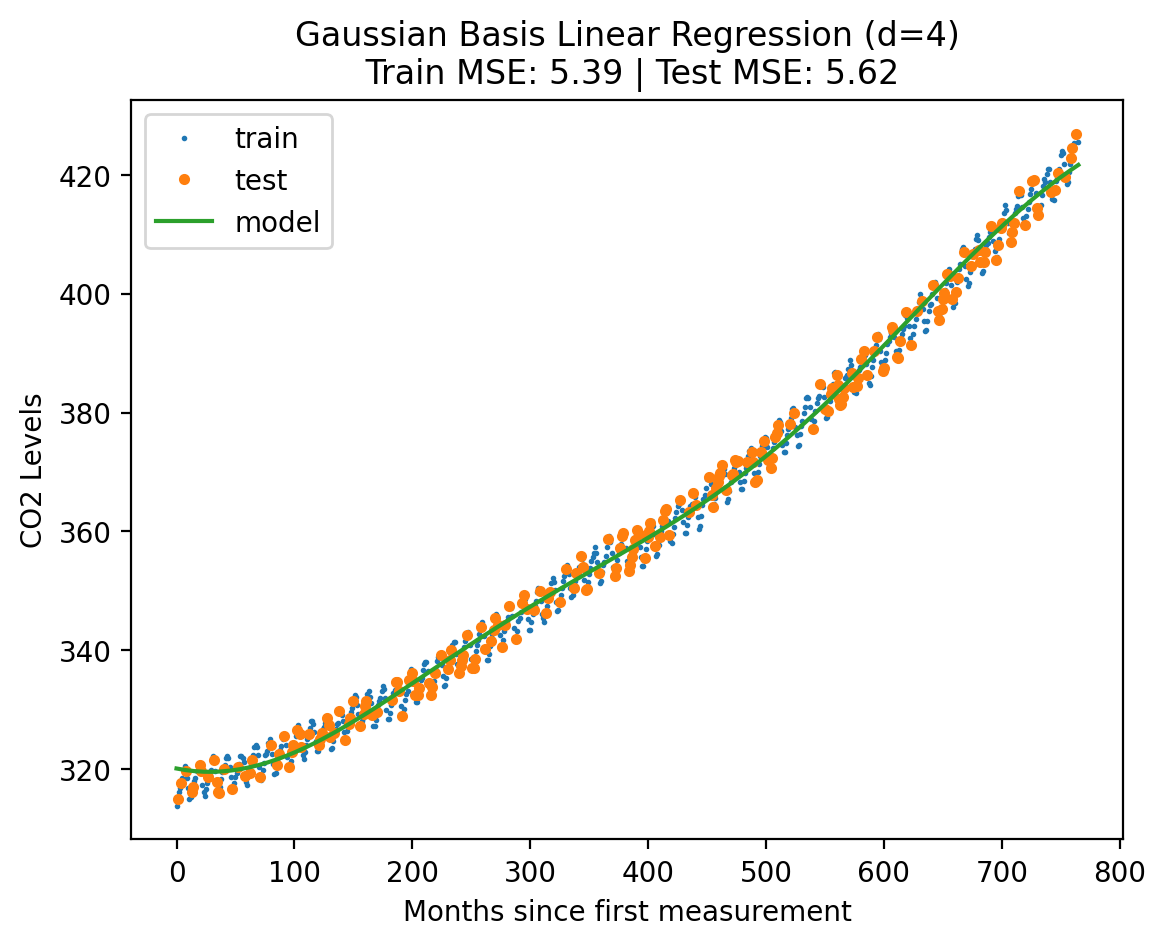

In [82]:
model_gauss = LinearRegression()
degree = 4
Xf_norm_train = create_guassian_basis(X_norm_train.reshape(-1, 1), degree)
Xf_norm_test = create_guassian_basis(X_norm_test.reshape(-1, 1), degree)

X_lin_poly = create_guassian_basis(X_lin_1d, degree)


plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Gaussian Basis Linear Regression (d={degree})")

In [83]:
errors.clear()

In [84]:
for degree in range(3, 7):
    Xf_norm_train = create_guassian_basis(X_norm_train.reshape(-1, 1), degree)
    Xf_norm_test = create_guassian_basis(X_norm_test.reshape(-1, 1), degree)

    X_lin_poly = create_guassian_basis(X_lin_1d, degree)


    plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Gaussian Basis Linear Regression (d={degree})", plot=False)

In [85]:
errors_df = pd.DataFrame(errors).T

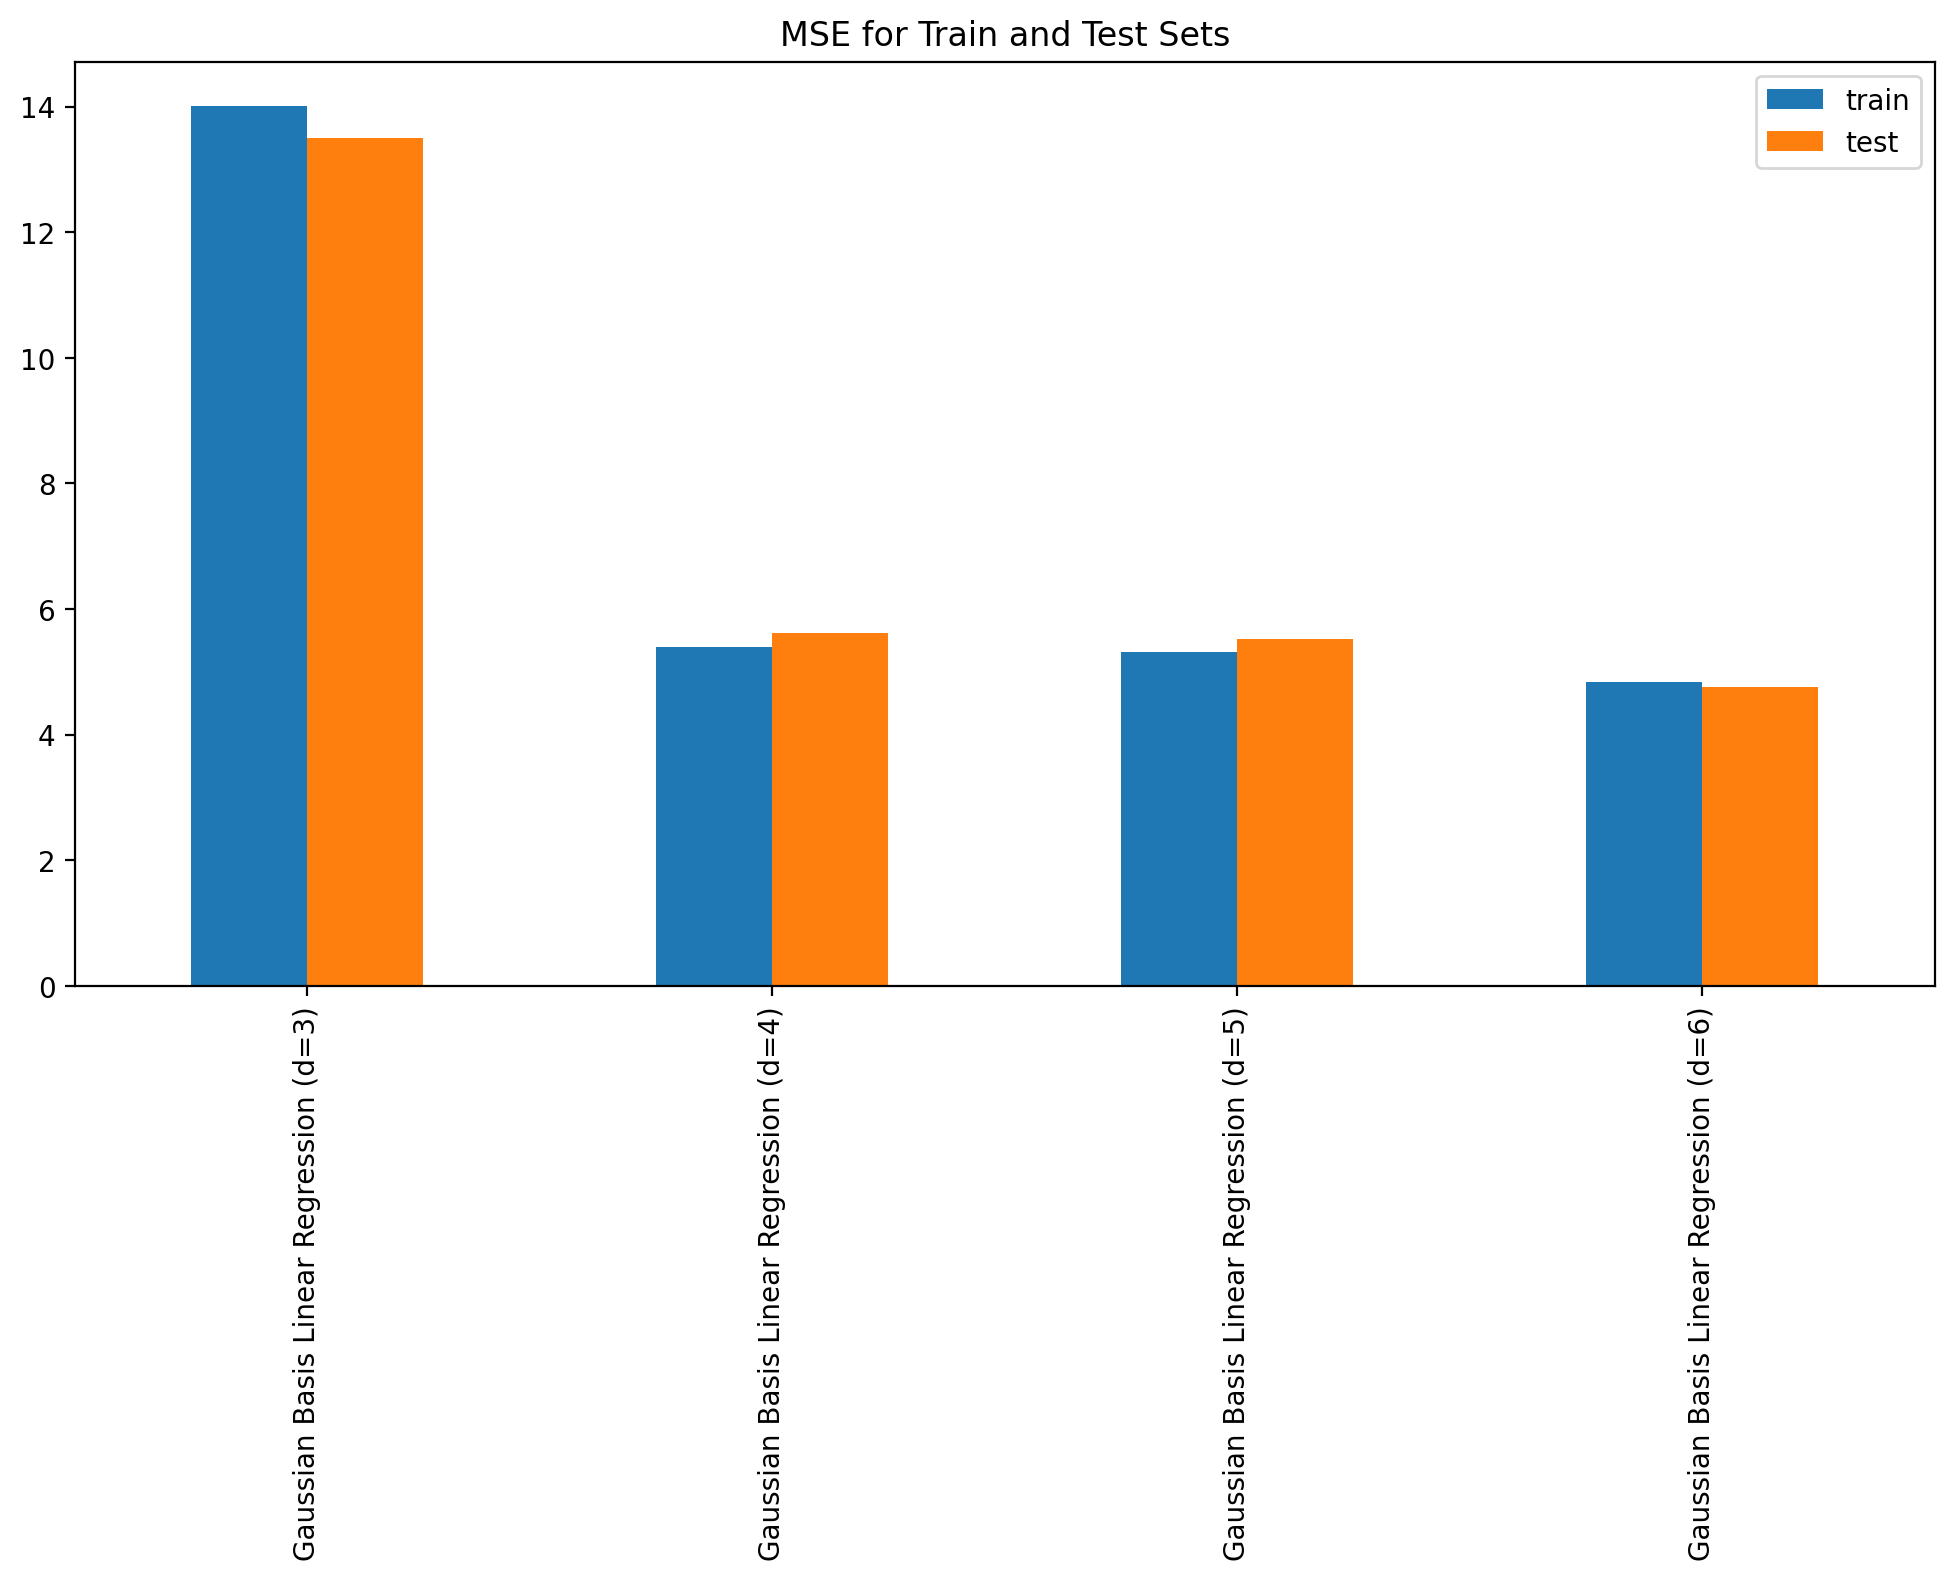

In [86]:
errors_df.plot(kind='bar', figsize=(12, 6), title='MSE for Train and Test Sets')

In [123]:
errors.clear()

In [124]:
# Bias Variance Tradeoff wrt Sigma

num_gaussians = 3
for std in [0.1, 0.5, 1, 2, 5, 10]:
    Xf_norm_train = create_guassian_basis(X_norm_train.reshape(-1, 1), num_gaussians, std)
    Xf_norm_test = create_guassian_basis(X_norm_test.reshape(-1, 1), num_gaussians, std)

    X_lin_poly = create_guassian_basis(X_lin_1d, num_gaussians, std)

    plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Gaussian Basis Linear Regression (d=3, std={std})", plot=False)

Text(0.5, 1.0, 'Bias Variance Tradeoff wrt Sigma')

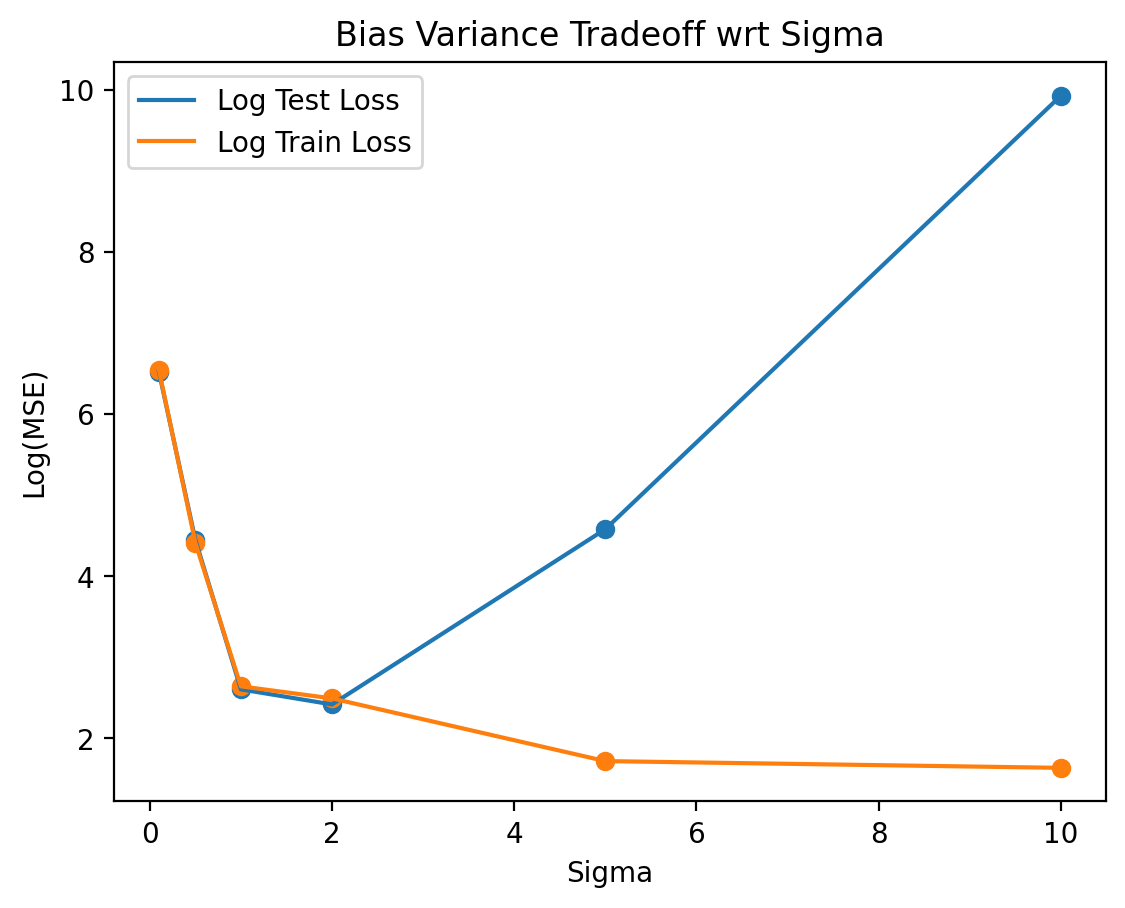

In [125]:
# Plot the train and test errors for different values of sigma

errors_df = pd.DataFrame(errors).T

test_errors = errors_df.test.values
train_errors = errors_df.train.values

log_test_errors = np.log(test_errors)
log_train_errors = np.log(train_errors)

stds = [0.1, 0.5, 1, 2, 5, 10]

plt.plot(stds , log_test_errors, label='Log Test Loss')
plt.plot(stds , log_train_errors, label='Log Train Loss')
plt.scatter(stds, log_test_errors)
plt.scatter(stds, log_train_errors)
plt.legend()
plt.xlabel('Sigma')
plt.ylabel('Log(MSE)')
plt.title('Bias Variance Tradeoff wrt Sigma')

### Gaussian Process

In [56]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
co2_kernel

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

In [57]:
# Using GP for the interpolation problem

from sklearn.gaussian_process import GaussianProcessRegressor

def plot_fit_gp(X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin, title, plot=True):

    gaussian_process = GaussianProcessRegressor(
        kernel=co2_kernel,n_restarts_optimizer=9
    )

    gaussian_process.fit(X_norm_train, y_norm_train)

    y_hat_train, std_prediction_train = gaussian_process.predict(X_norm_train, return_std=True)
    y_hat_test , std_prediction_test = gaussian_process.predict(X_norm_test, return_std=True)

    y_hat_train = y_hat_train.reshape(-1, 1)
    y_hat_test = y_hat_test.reshape(-1, 1)

    # Transform back to original scale
    y_hat_train = s2.inverse_transform(y_hat_train)
    y_hat_test = s2.inverse_transform(y_hat_test)

    y_hat_lin , std_prediction_lin = gaussian_process.predict(X_lin , return_std=True)
    y_hat_lin = y_hat_lin.reshape(-1, 1)
    y_hat_lin = s2.inverse_transform(y_hat_lin)

    errors[title] = {"train": mean_squared_error(y_train, y_hat_train),
                     "test": mean_squared_error(y_test, y_hat_test)}

    if plot:
        plt.plot(X_train, y_train, 'o', label='train',markersize=1)
        plt.plot(X_test, y_test, 'o', label='test', ms=3)
        plt.plot(s1.inverse_transform(X_lin_1d), y_hat_lin, label='model')
        plt.fill_between(s1.inverse_transform(X_lin_1d).reshape(-1), 
                         (y_hat_lin - 1.96*std_prediction_lin.reshape(-1,1)).reshape(-1), 
                         (y_hat_lin + 1.96*std_prediction_lin.reshape(-1,1)).reshape(-1), alpha=0.5 , label='95% Confidence interval')
        plt.xlabel('Months since first measurement')
        plt.ylabel('CO2 Levels')
        plt.legend()

        plt.title('{}\n Train MSE: {:.2f} | Test MSE: {:.2f}'.format(title, errors[title]["train"], errors[title]["test"]))

    return errors[title]

In [58]:
plot_fit_gp(X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin_1d, "Gaussian Process Regression")

### Fourier Features

Reference: https://bmild.github.io/fourfeat/

##### Fourier Feature Mapping

For every input x, we map it to a higher dimensional space using the
following function:

$$\gamma(x) = [\cos(2\pi Bx), \sin(2\pi Bx)]^{T} $$

where $B$ is a random Gaussian matrix, where each entry is drawn
independently from a normal distribution N(0, $σ^{2}$)

[ 2.48357077 -0.69132151  3.23844269  7.61514928 -1.17076687]

Text(0.5, 1.0, 'Fourier Featurization of X manually')

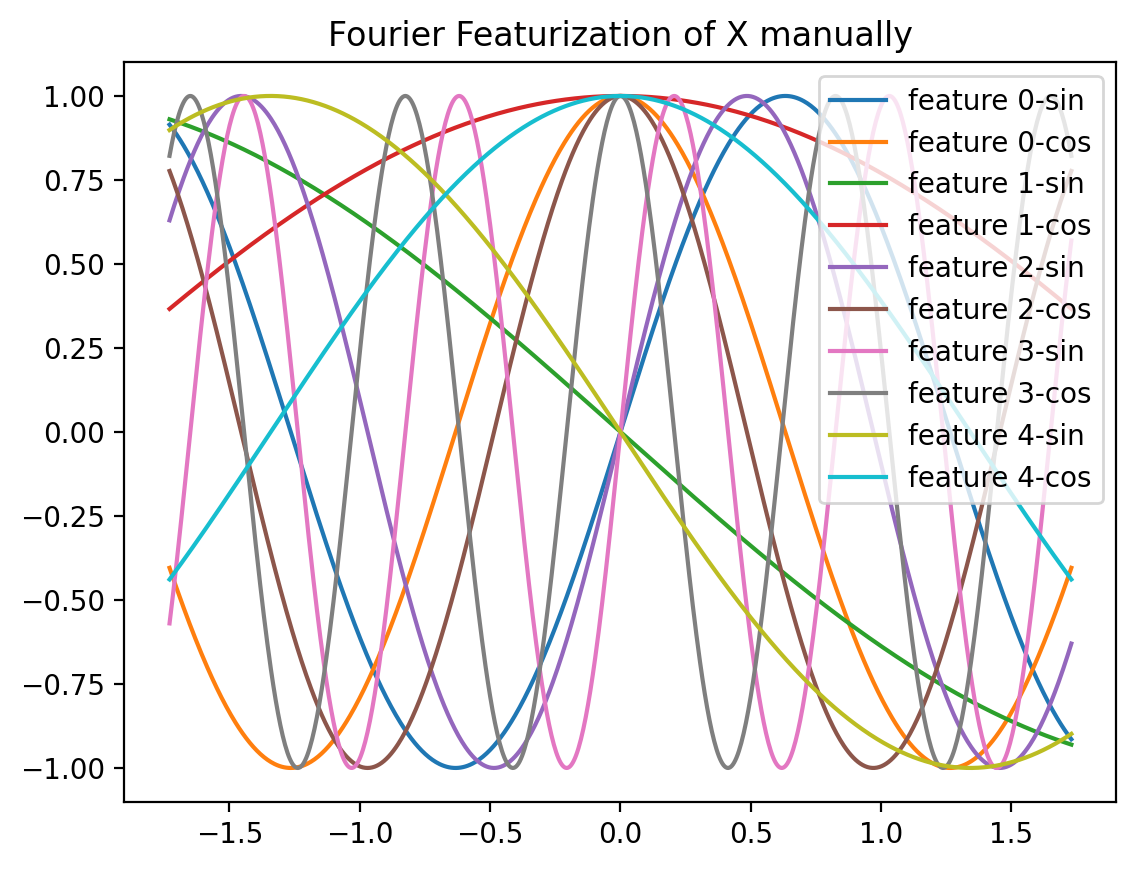

In [107]:
np.random.seed(42)
sigma = 5
NUM_features = 5
fs = sigma*np.random.randn(NUM_features)
print(fs)

for i in range(NUM_features):
    plt.plot(X_norm, np.sin(fs[i]*X_norm), label=f'feature {i}-sin')
    plt.plot(X_norm, np.cos(fs[i]*X_norm), label=f'feature {i}-cos')
plt.legend()
plt.title('Fourier Featurization of X manually')

In [108]:
# Explicit implementation of RFF

def create_random_features(X, gamma, NUM_features):
    """
    X is (N, 1) array
    gamma is a scalar
    NUM_features is a scalar
    """
    
    X_rff = np.zeros((len(X), 2*NUM_features + 1))
    X_rff[:, 0] = X[:, 0]
    for i in range(NUM_features):
        b = np.random.randn()
        X_rff[:, i+1] = np.sin(2*np.pi*gamma*b*X[:, 0])
        X_rff[:, i + NUM_features+1] = np.cos(2*np.pi*gamma*b*X[:, 0])
    
    # Normalize each column
    X_rff = StandardScaler().fit_transform(X_rff)
    return X_rff


##### Sklearn Implementation

In [109]:
# Sklearn's implementation of RFF

from sklearn.kernel_approximation import RBFSampler
RBFSampler?

Text(0.5, 1.0, 'Fourier Featurization using RBFSampler (sklearn)')

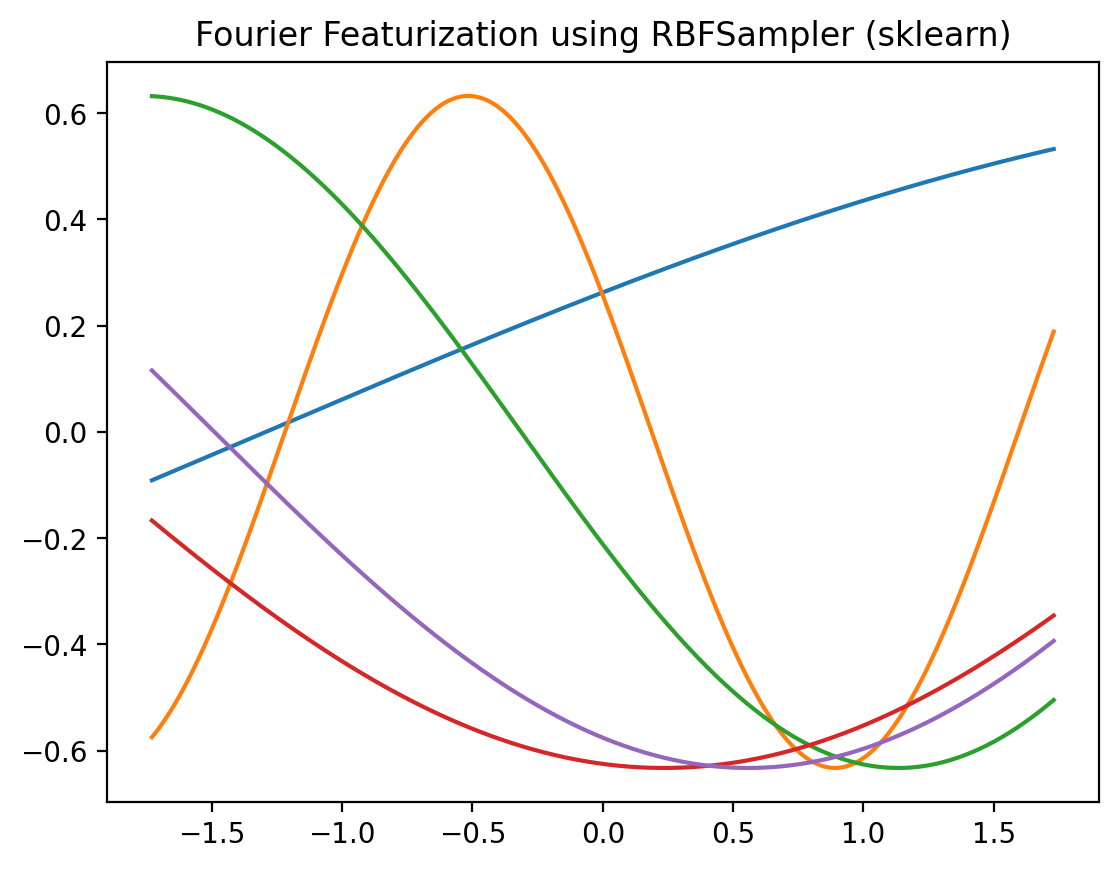

In [88]:
r= RBFSampler(n_components=5)
plt.plot(X_norm, r.fit_transform(X_norm.reshape(-1,1)))
plt.title('Fourier Featurization using RBFSampler (sklearn)')

Text(0.5, 1.0, 'Fourier Featurization using RBFSampler (sklearn)')

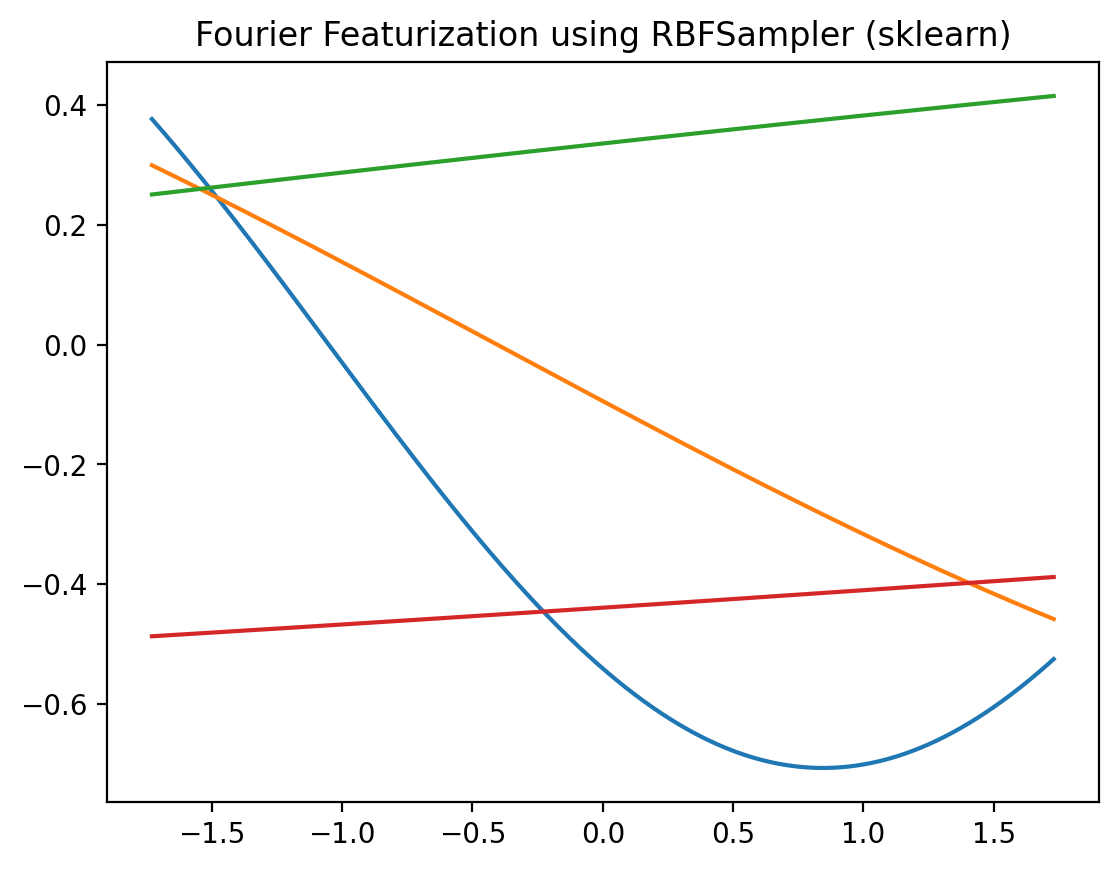

In [115]:
r = RBFSampler(n_components=4, gamma=0.1)
plt.plot(X_norm, r.fit_transform(X_norm.reshape(-1,1)))
plt.title('Fourier Featurization using RBFSampler (sklearn)')

Text(0.5, 1.0, 'Fourier Featurization using RBFSampler (sklearn)')

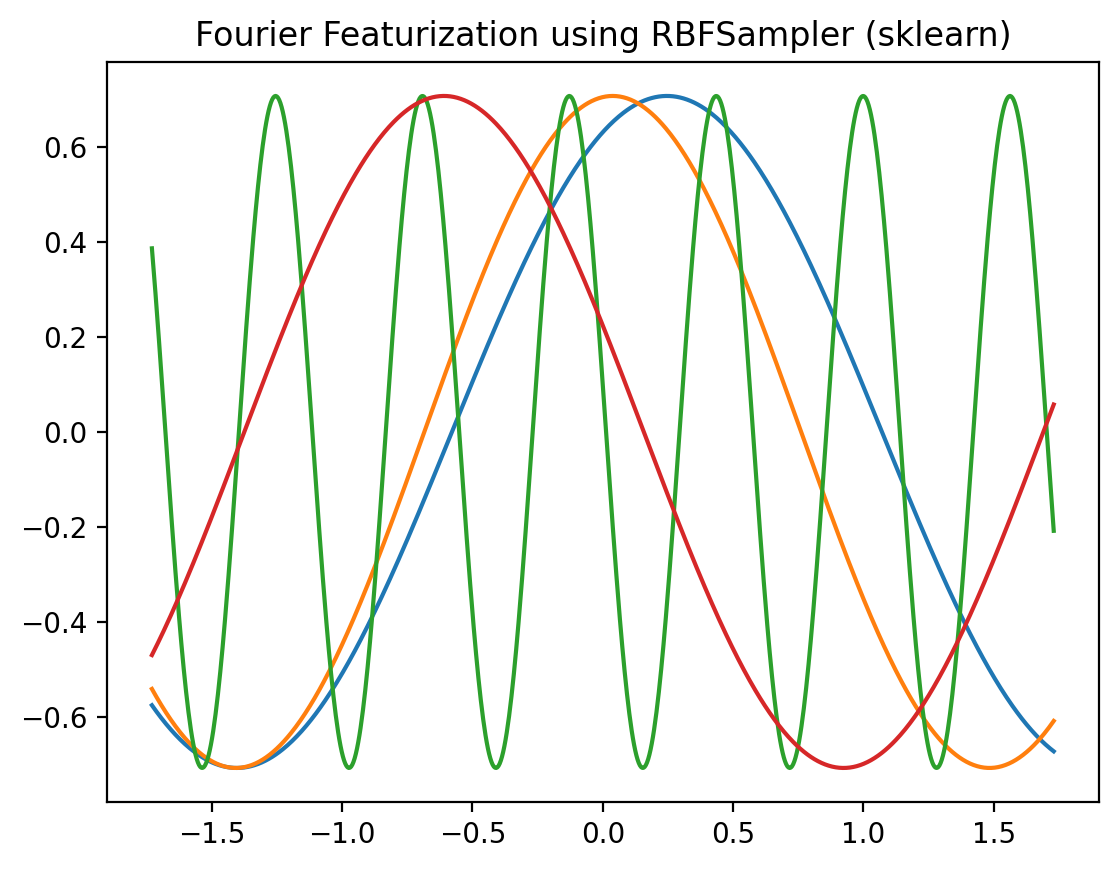

In [116]:
r = RBFSampler(n_components=4, gamma=20)
plt.plot(X_norm, r.fit_transform(X_norm.reshape(-1,1)))
plt.title('Fourier Featurization using RBFSampler (sklearn)')

In [112]:
# Implicit implementation of RFF using sklearn

def create_rff(X, gamma, NUM_features):
    # Random Fourier Features
    # https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html
    rbf_feature = RBFSampler(gamma=gamma, n_components=NUM_features, random_state=1)
    X_features = rbf_feature.fit_transform(X)
    return X_features

{'train': 4.630893826442012, 'test': 4.626609156411284}

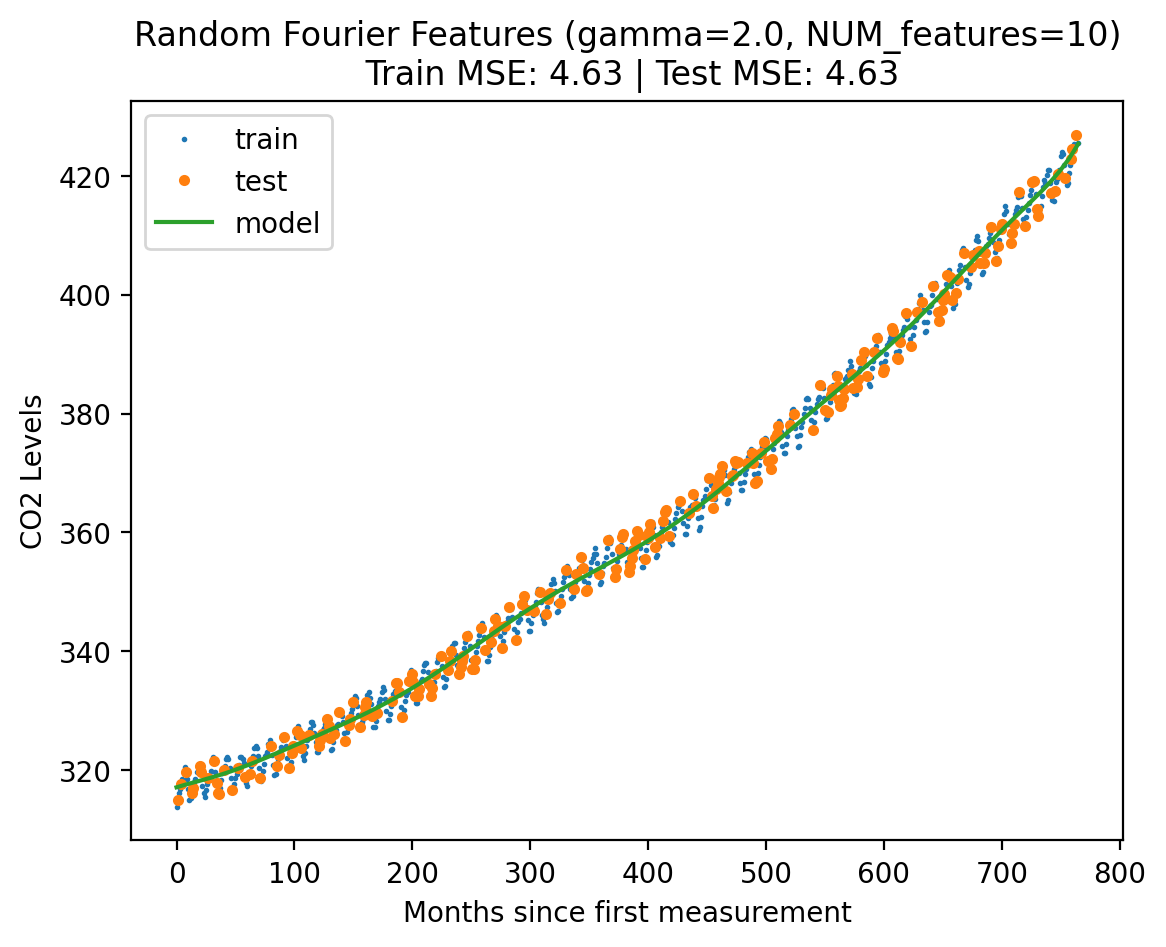

In [118]:
model3 = LinearRegression()
gamma = 2.0
NUM_features = 10

Xf_norm_train = create_rff(X_norm_train.reshape(-1, 1), gamma, NUM_features)
Xf_norm_test = create_rff(X_norm_test.reshape(-1, 1), gamma, NUM_features)

X_lin_rff = create_rff(X_lin_1d, gamma, NUM_features)

plot_fit_predict(model3, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_rff, f"Random Fourier Features (gamma={gamma}, NUM_features={NUM_features})")

##### Bias-Variance Tradeoff for Fourier Features

w.r.t gamma

In [119]:
model4 = LinearRegression()

# NUM_features_values = [1, 2, 3, 4, 5, 10, 20, 50, 100]
gamma_values = [0.01, 0.1, 1, 2, 5, 10]

errors_rff = {}

for gamma in gamma_values:
    # gamma = 2.0
    NUM_features_ = 100
    Xf_norm_train = create_rff(X_norm_train.reshape(-1, 1), gamma, NUM_features_)
    Xf_norm_test = create_rff(X_norm_test.reshape(-1, 1), gamma, NUM_features_)

    X_lin_rff = create_rff(X_lin_1d, gamma, NUM_features_)

    plot_fit_predict(model4, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_rff, gamma, plot=False)

    errors_rff[gamma] = errors[gamma]

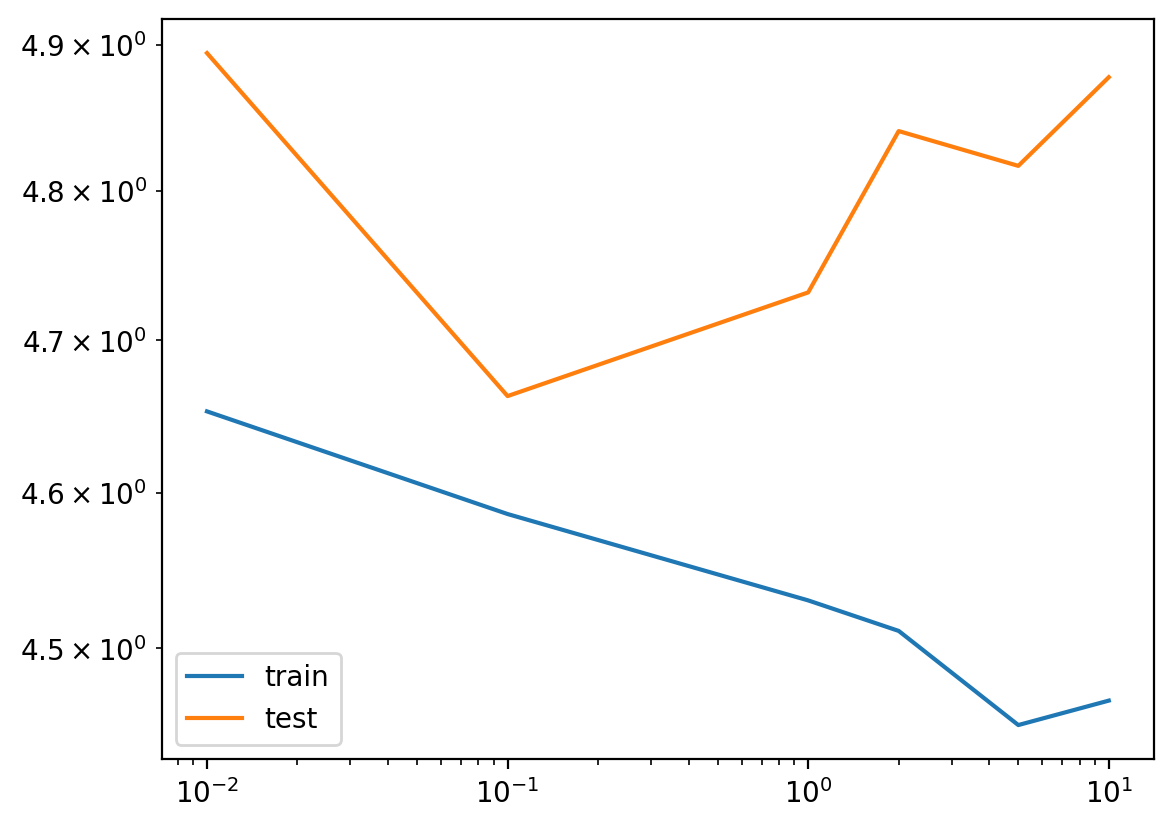

In [120]:
pd.DataFrame(errors_rff).T.plot(logy=True, logx=True)

### Extrapolation using Gaussian Process

In [233]:
X_norm_train = X_norm[:int(len(X_norm)*0.7)]
X_norm_test = X_norm[int(len(X_norm)*0.7):]

y_norm_train = y_norm[:int(len(y_norm)*0.7)]
y_norm_test = y_norm[int(len(y_norm)*0.7):]

X_train = X[:int(len(X)*0.7)]
X_test = X[int(len(X)*0.7):]

y_train = y[:int(len(y)*0.7)]
y_test = y[int(len(y)*0.7):]

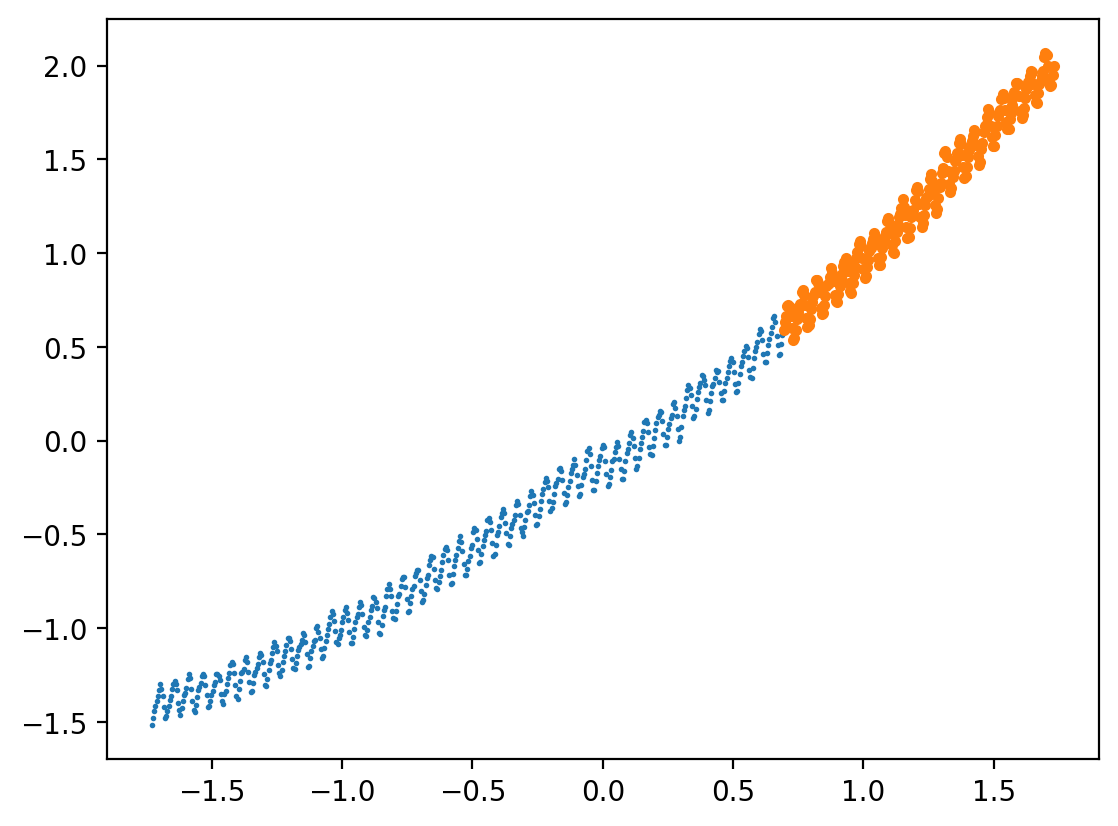

In [234]:
plt.plot(X_norm_train, y_norm_train, 'o', label='train',markersize=1)
plt.plot(X_norm_test, y_norm_test, 'o', label='test', ms=3)

In [235]:
plot_fit_gp(X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin_1d, "Gaussian Process Extrapolation Regression")

### Before this…

# Dataset 1: Sine wave with noise

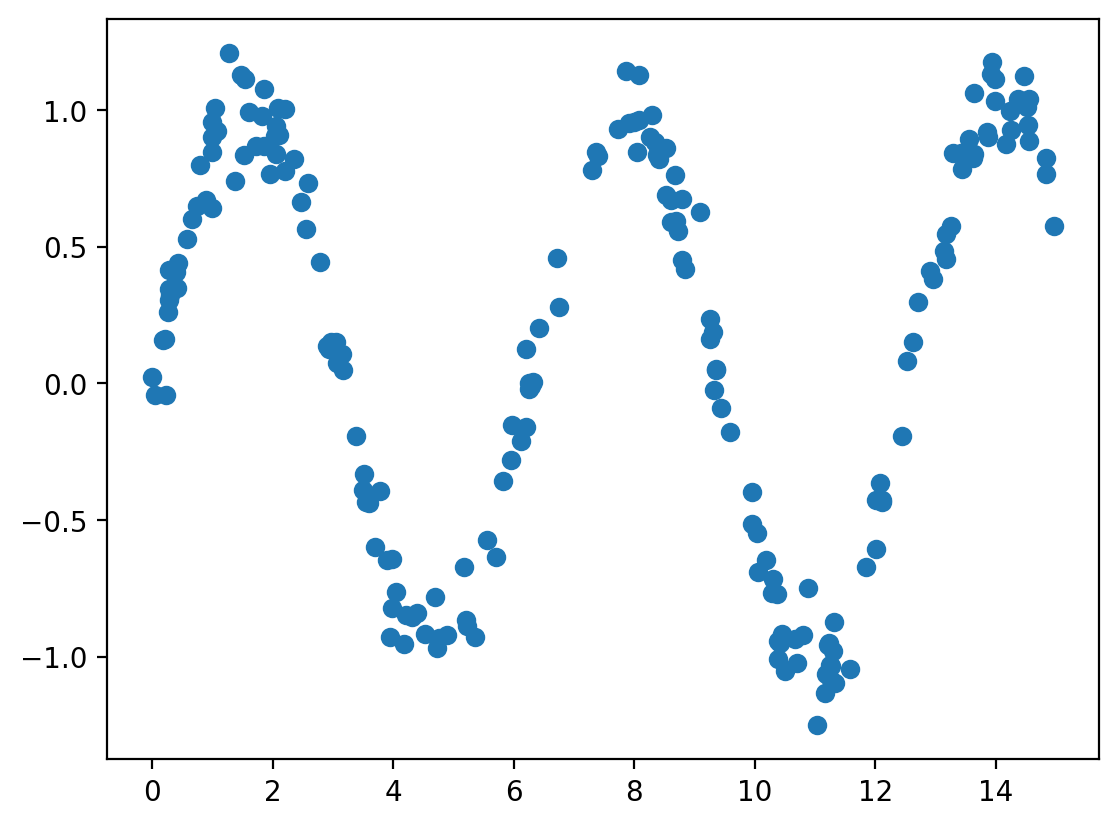

In [67]:
# Generate some data
rng = np.random.RandomState(1)
x = 15 * rng.rand(200)
y = np.sin(x) + 0.1 * rng.randn(200)
df = pd.DataFrame({'x': x, 'y': y})

# plot the data
plt.scatter(df.x, df.y)
plt.show()

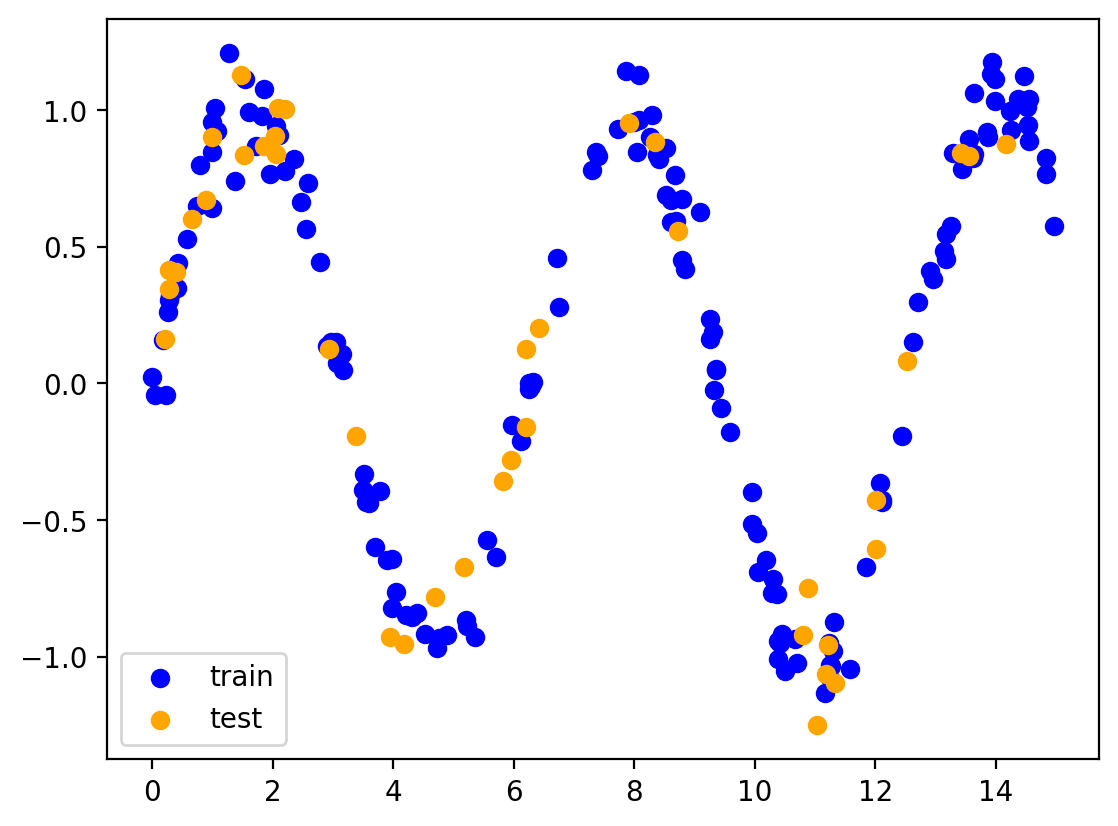

In [68]:
# Train test split
train = df.sample(frac=0.8, random_state=1)
test = df.drop(train.index)

plt.scatter(train.x, train.y, color='blue', label='train')
plt.scatter(test.x, test.y, color='orange', label='test')
plt.legend()
plt.show()

In [69]:
def plot_predictions(train, test, yhat_train, yhat_test):
        
    # add yhat_train to train and yhat_test to test
    train['yhat'] = yhat_train
    test['yhat'] = yhat_test

    # sort train and test by x
    train = train.sort_values(by='x')
    test = test.sort_values(by='x')

    # Train and test error
    train_rmse = np.sqrt(np.mean((train.yhat - train.y)**2))
    test_rmse = np.sqrt(np.mean((test.yhat - test.y)**2))

    plt.scatter(train.x, train.y, color='blue', label='train')
    plt.scatter(test.x, test.y, color='orange', label='test')
    plt.plot(train.x, train.yhat, color='red', label='train prediction')
    plt.plot(test.x, test.yhat, color='green', label='test prediction')
    plt.title('Train RMSE: {:.3f}, Test RMSE: {:.3f}'.format(train_rmse, test_rmse))
    plt.legend()
    plt.show()

    return train_rmse, test_rmse

In [70]:
# Hyperparameter tuning using grid search and showing bias variance tradeoff
def hyperparameter_tuning(params, train, test, model):
    train_rmse = []
    test_rmse = []

    for d in params:
        yhat_train, yhat_test = model(d, train, test)
        train_rmse.append(np.sqrt(np.mean((yhat_train - train.y)**2)))
        test_rmse.append(np.sqrt(np.mean((yhat_test - test.y)**2)))

    plt.plot(params, train_rmse, label='train')
    plt.plot(params, test_rmse, label='test')
    plt.xlabel('params')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

    optimal_param = params[np.argmin(test_rmse)]

    return optimal_param

In [71]:
rmse_dict = {}

### Model 1: MLP

In [72]:
# use sk-learn for MLP
mlp_model = MLPRegressor(hidden_layer_sizes=[128, 256, 512, 256, 128], max_iter = 10000)
mlp_model.fit(np.array(train.x).reshape(-1, 1), train.y)

MLPRegressor(hidden_layer_sizes=[128, 256, 512, 256, 128], max_iter=10000) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. MLPRegressor MLPRegressor(hidden_layer_sizes=[128, 256, 512, 256, 128], max_iter=10000)

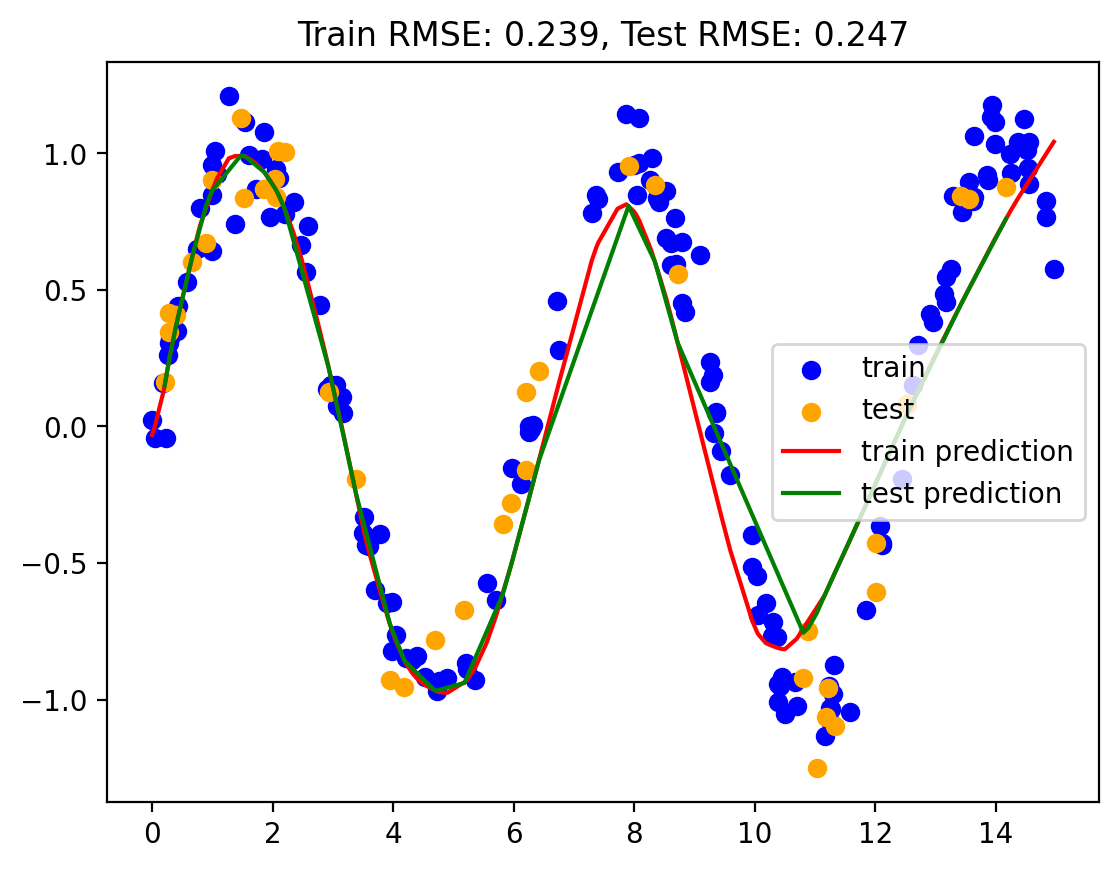

In [73]:
yhat_train = mlp_model.predict(np.array(train.x).reshape(-1, 1))
yhat_test = mlp_model.predict(np.array(test.x).reshape(-1, 1))
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['MLP'] = (train_rmse, test_rmse)

### Model 2: Vanilla Linear Regression

In [74]:
lr1 = LinearRegression()
lr1.fit(np.array(train.x).reshape(-1, 1), train.y)

LinearRegression() In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. LinearRegression LinearRegression()

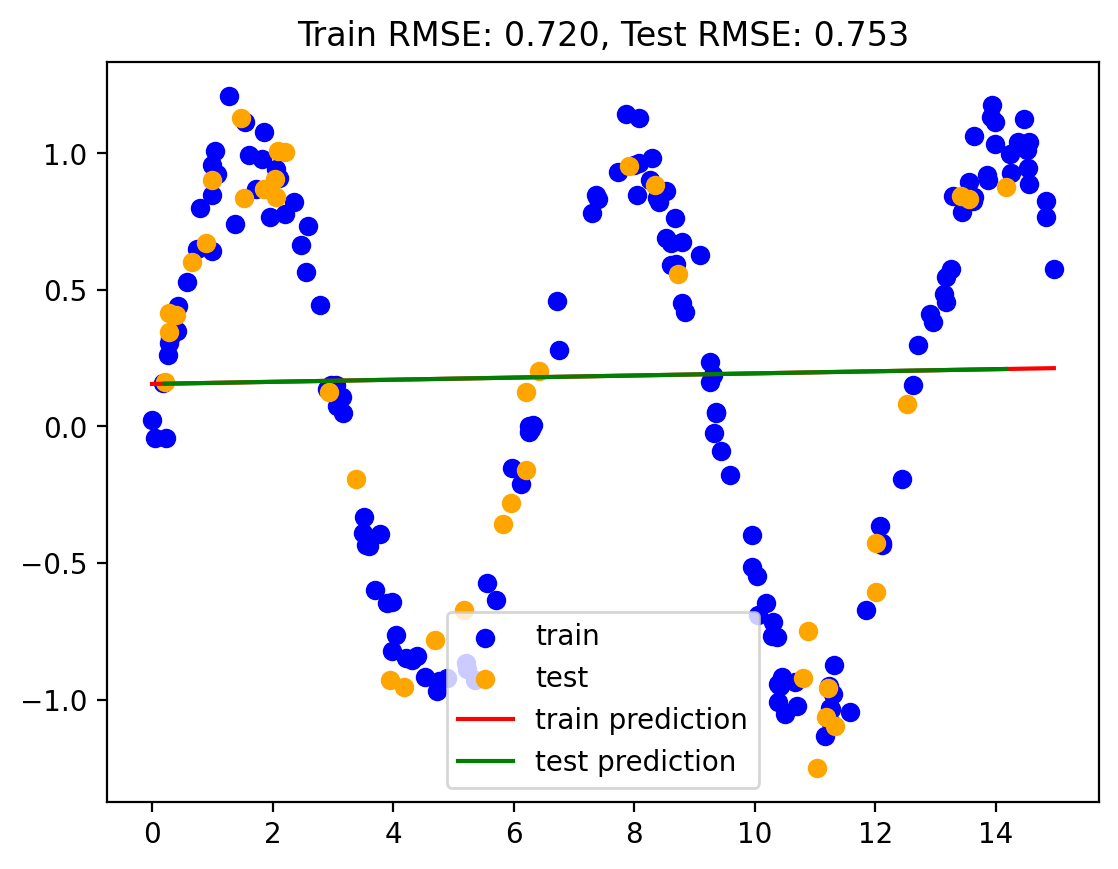

In [75]:
yhat_train = lr1.predict(np.array(train.x).reshape(-1, 1))
yhat_test = lr1.predict(np.array(test.x).reshape(-1, 1))
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Vanilla LR'] = (train_rmse, test_rmse)

### Model 3: Polynomial regression with degree d

In [76]:
def poly_regression(d, train, test):
    lr = LinearRegression()
    pf = PolynomialFeatures(degree=d)
    
    X_train = pf.fit_transform(train.x.values.reshape(-1, 1))
    X_test = pf.fit_transform(test.x.values.reshape(-1, 1))
    
    lr.fit(X_train, train.y)
    
    yhat_train = lr.predict(X_train)
    yhat_test = lr.predict(X_test)

    return yhat_train, yhat_test

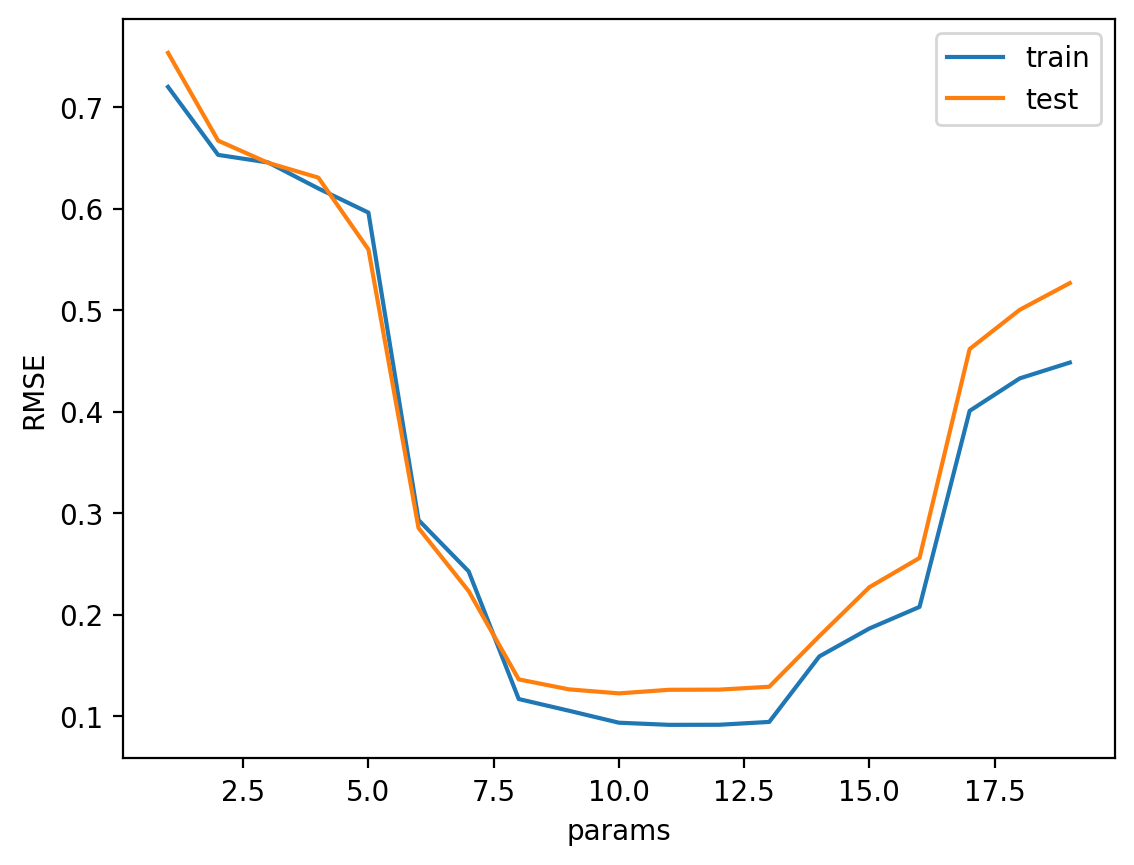

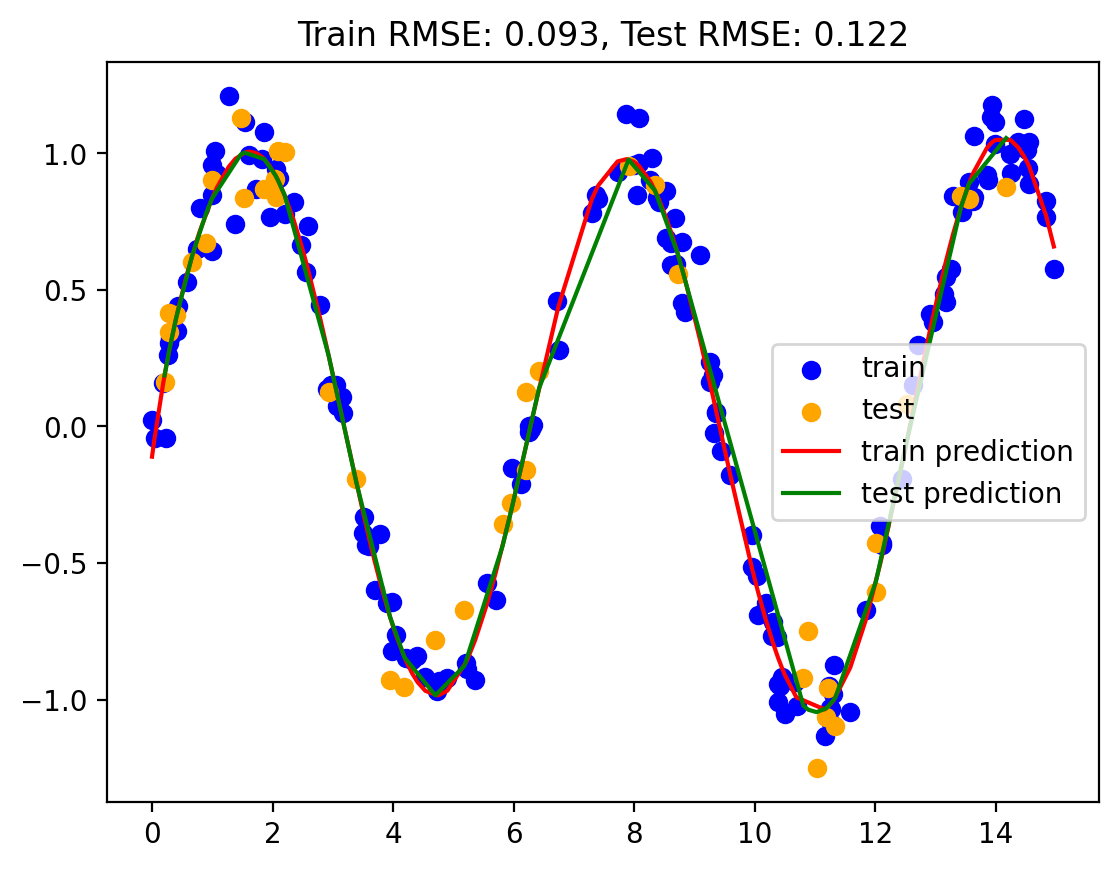

Best degree:  10

In [77]:
# Hyperparameter tuning using grid search and showing bias variance tradeoff
degrees = range(1, 20)
best_degree = hyperparameter_tuning(degrees, train, test, poly_regression)
yhat_train, yhat_test = poly_regression(best_degree, train, test)
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Polynomial Regression'] = (train_rmse, test_rmse)
print("Best degree: ", best_degree)

### Model 4: Linear regression with sine and cosine basis functions

In [78]:
def sine_basis_regression(num_basis, train, test):
    lr = LinearRegression()
    for i in range(1, num_basis+1):
        train[f"sine_{i}"] = np.sin(i*train.x)
        train[f"cosine_{i}"] = np.cos(i*train.x)
        test[f"sine_{i}"] = np.sin(i*test.x)
        test[f"cosine_{i}"] = np.cos(i*test.x)
    
    X_train = train.drop(['y'], axis=1)
    X_test = test.drop(['y'], axis=1)
    
    lr.fit(X_train, train.y)

    yhat_train = lr.predict(X_train)
    yhat_test = lr.predict(X_test)

    return yhat_train, yhat_test

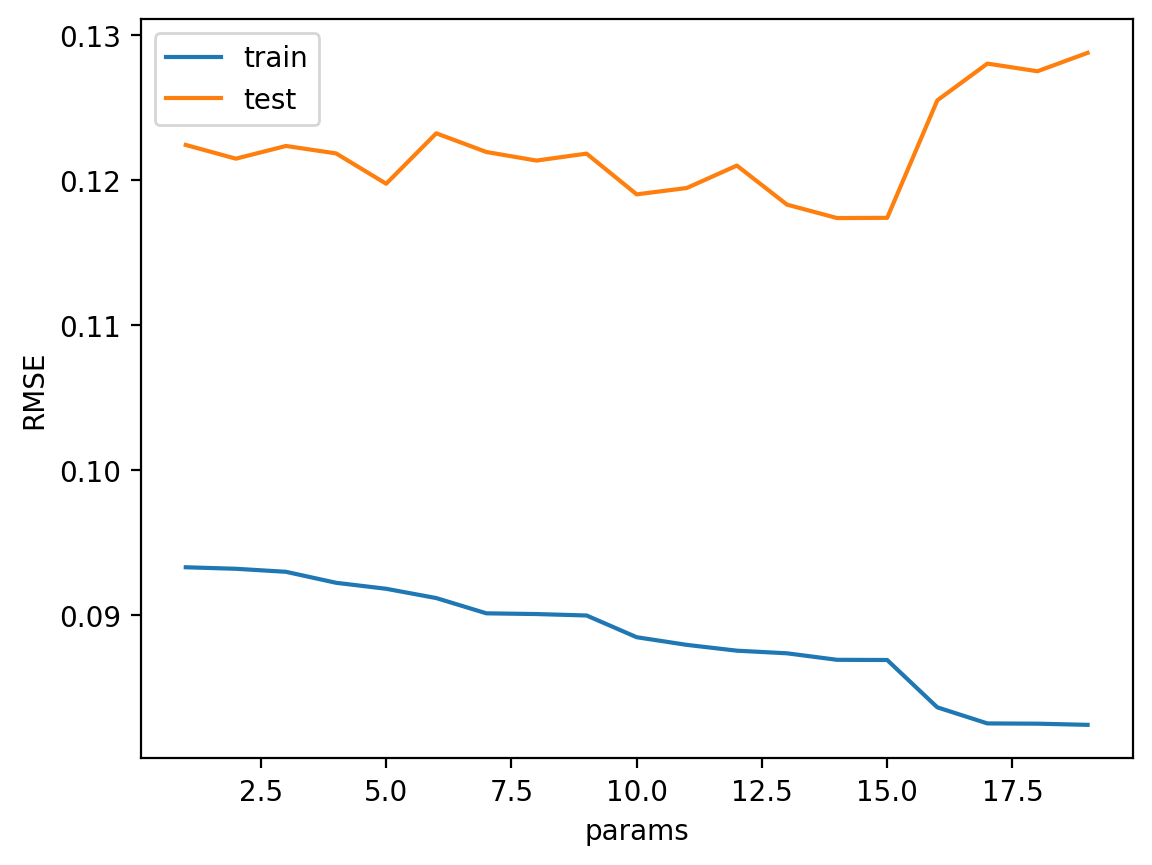

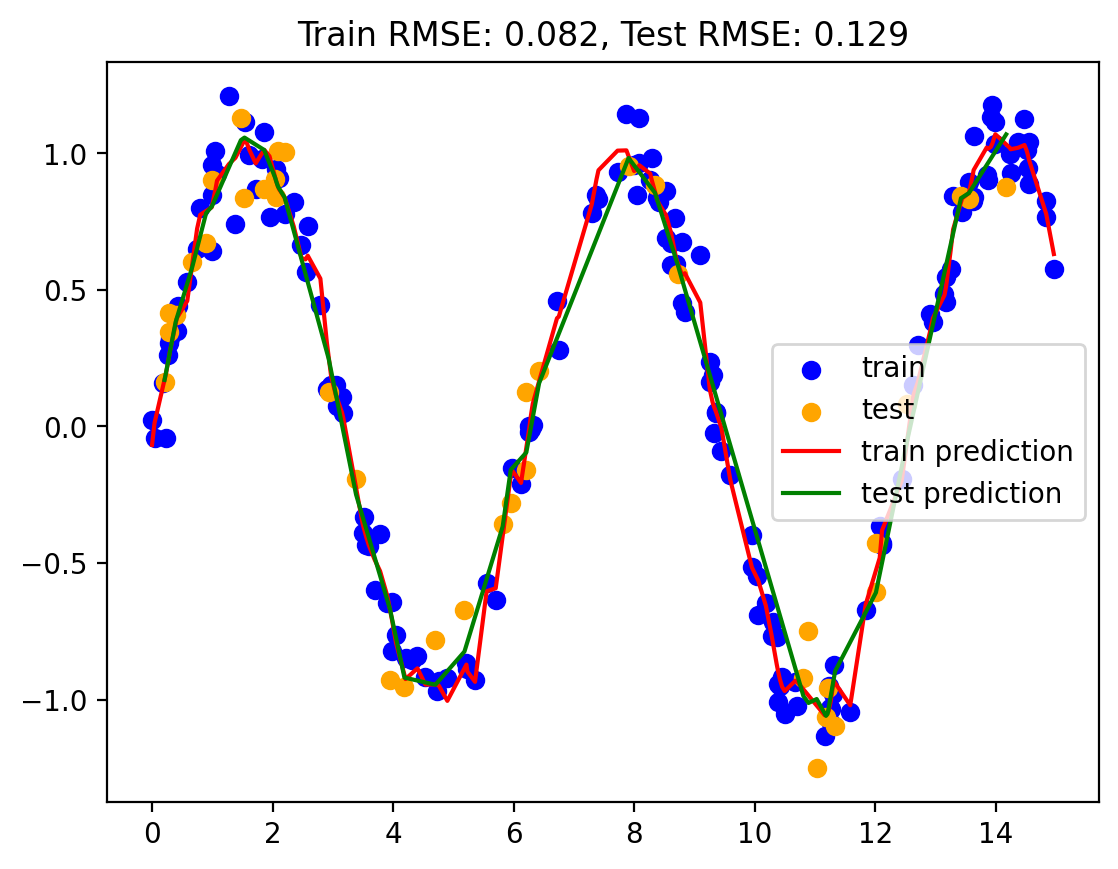

Best number of basis:  14

In [79]:
basis = range(1, 20)
best_num_basis = hyperparameter_tuning(basis, train, test, sine_basis_regression)
yhat_train, yhat_test = sine_basis_regression(best_num_basis, train, test)
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Sine Basis Regression'] = (train_rmse, test_rmse)
print("Best number of basis: ", best_num_basis)

### Model 5: Linear regression with Gaussian basis functions

In [80]:
# Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Gaussian-basis-functions

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """
    Uniformly spaced Gaussian features for one-dimensional input
    
    Constructor with N centers and width_factor as hyperparameters
    N comes from the number of basis functions
    width_factor is the width of each basis function
    """
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

Best number of basis:  13

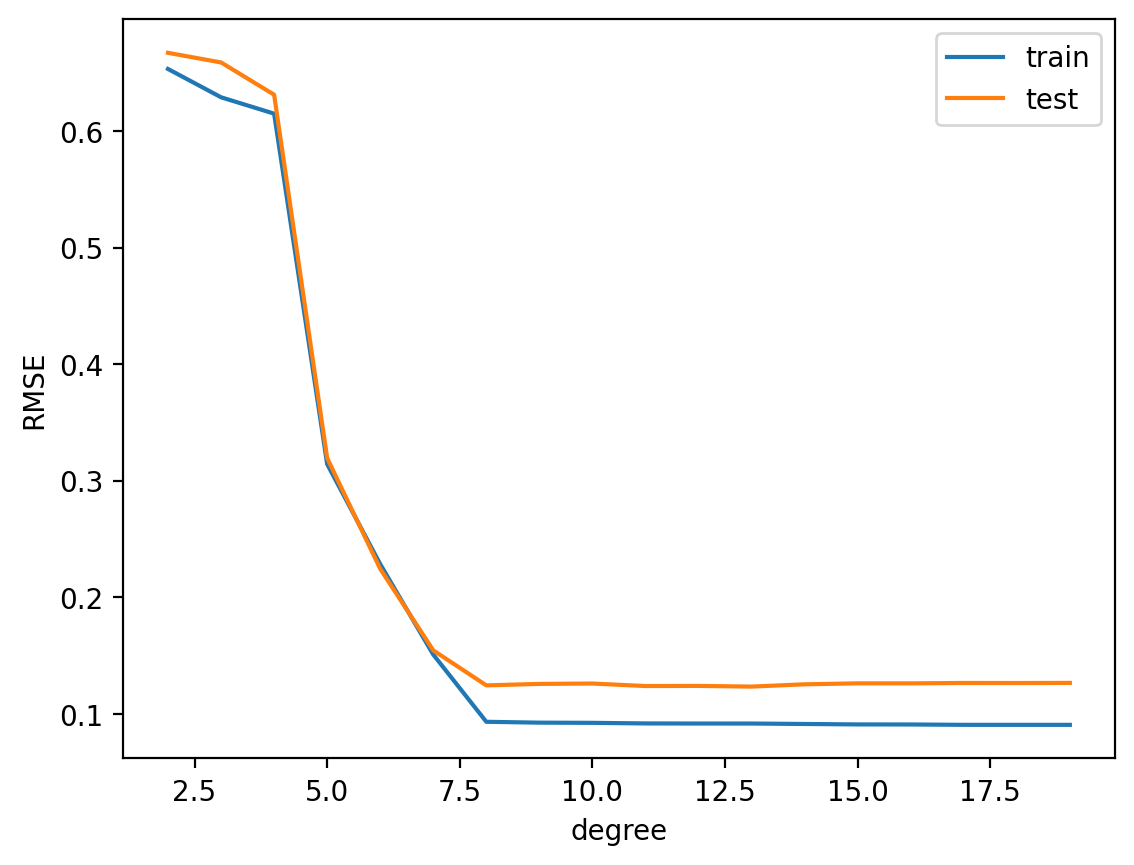

In [81]:
# Hyperparameter tuning
basis = range(2, 20)

train_rmse = []
test_rmse = []
for d in basis:
    model = make_pipeline(GaussianFeatures(d), LinearRegression())
    model.fit(np.array(train.x).reshape(-1, 1), train.y)
    yhat_train = model.predict(np.array(train.x).reshape(-1, 1))
    yhat_test = model.predict(np.array(test.x).reshape(-1, 1))
    train_rmse.append(np.sqrt(np.mean((yhat_train - train.y)**2)))
    test_rmse.append(np.sqrt(np.mean((yhat_test - test.y)**2)))

best_num_basis = basis[np.argmin(test_rmse)]
print("Best number of basis: ", best_num_basis)
plt.plot(basis, train_rmse, label='train')
plt.plot(basis, test_rmse, label='test')
plt.xlabel('degree')
plt.ylabel('RMSE')
plt.legend()
plt.show()

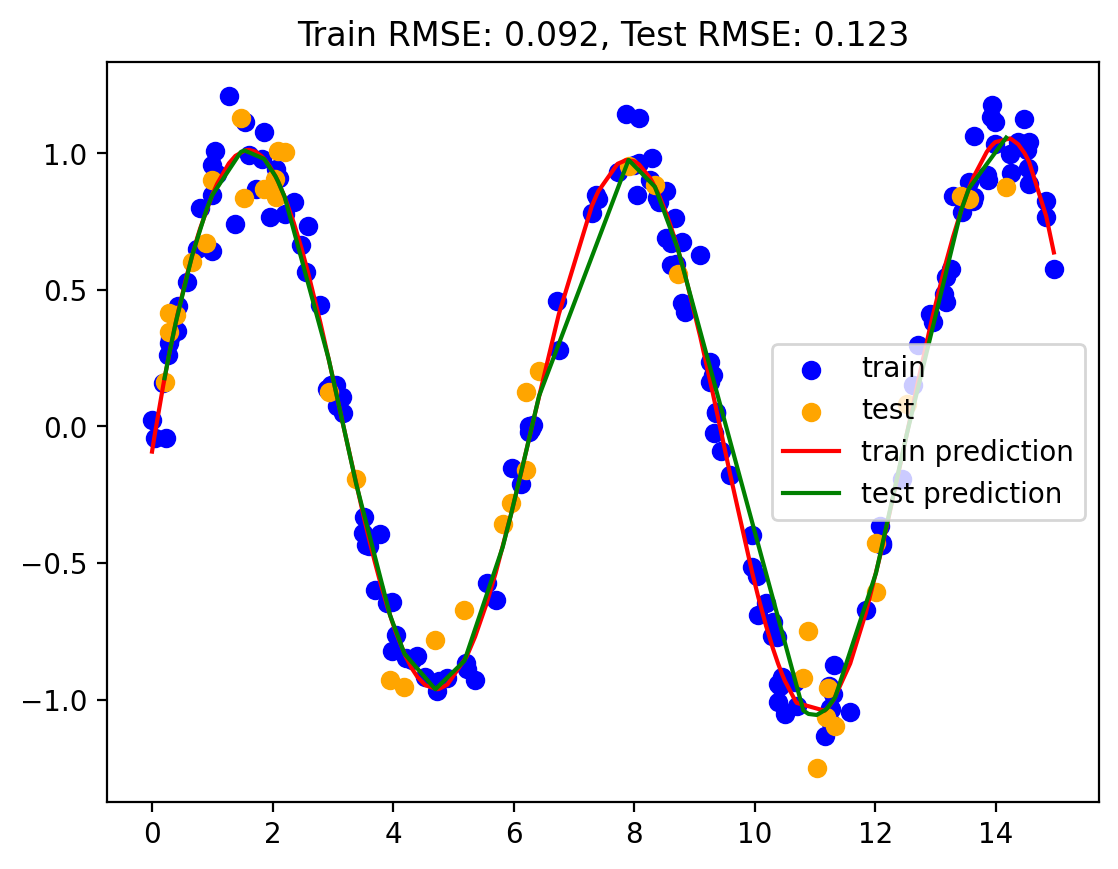

In [82]:
gauss_model = make_pipeline(GaussianFeatures(best_num_basis), LinearRegression())
gauss_model.fit(np.array(train.x).reshape(-1, 1), train.y)
yhat_train = gauss_model.predict(train.x.values.reshape(-1, 1))
yhat_test = gauss_model.predict(test.x.values.reshape(-1, 1))
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Gaussian Basis Regression'] = (train_rmse, test_rmse)

#### Plotting rmse using different variants of linear regression

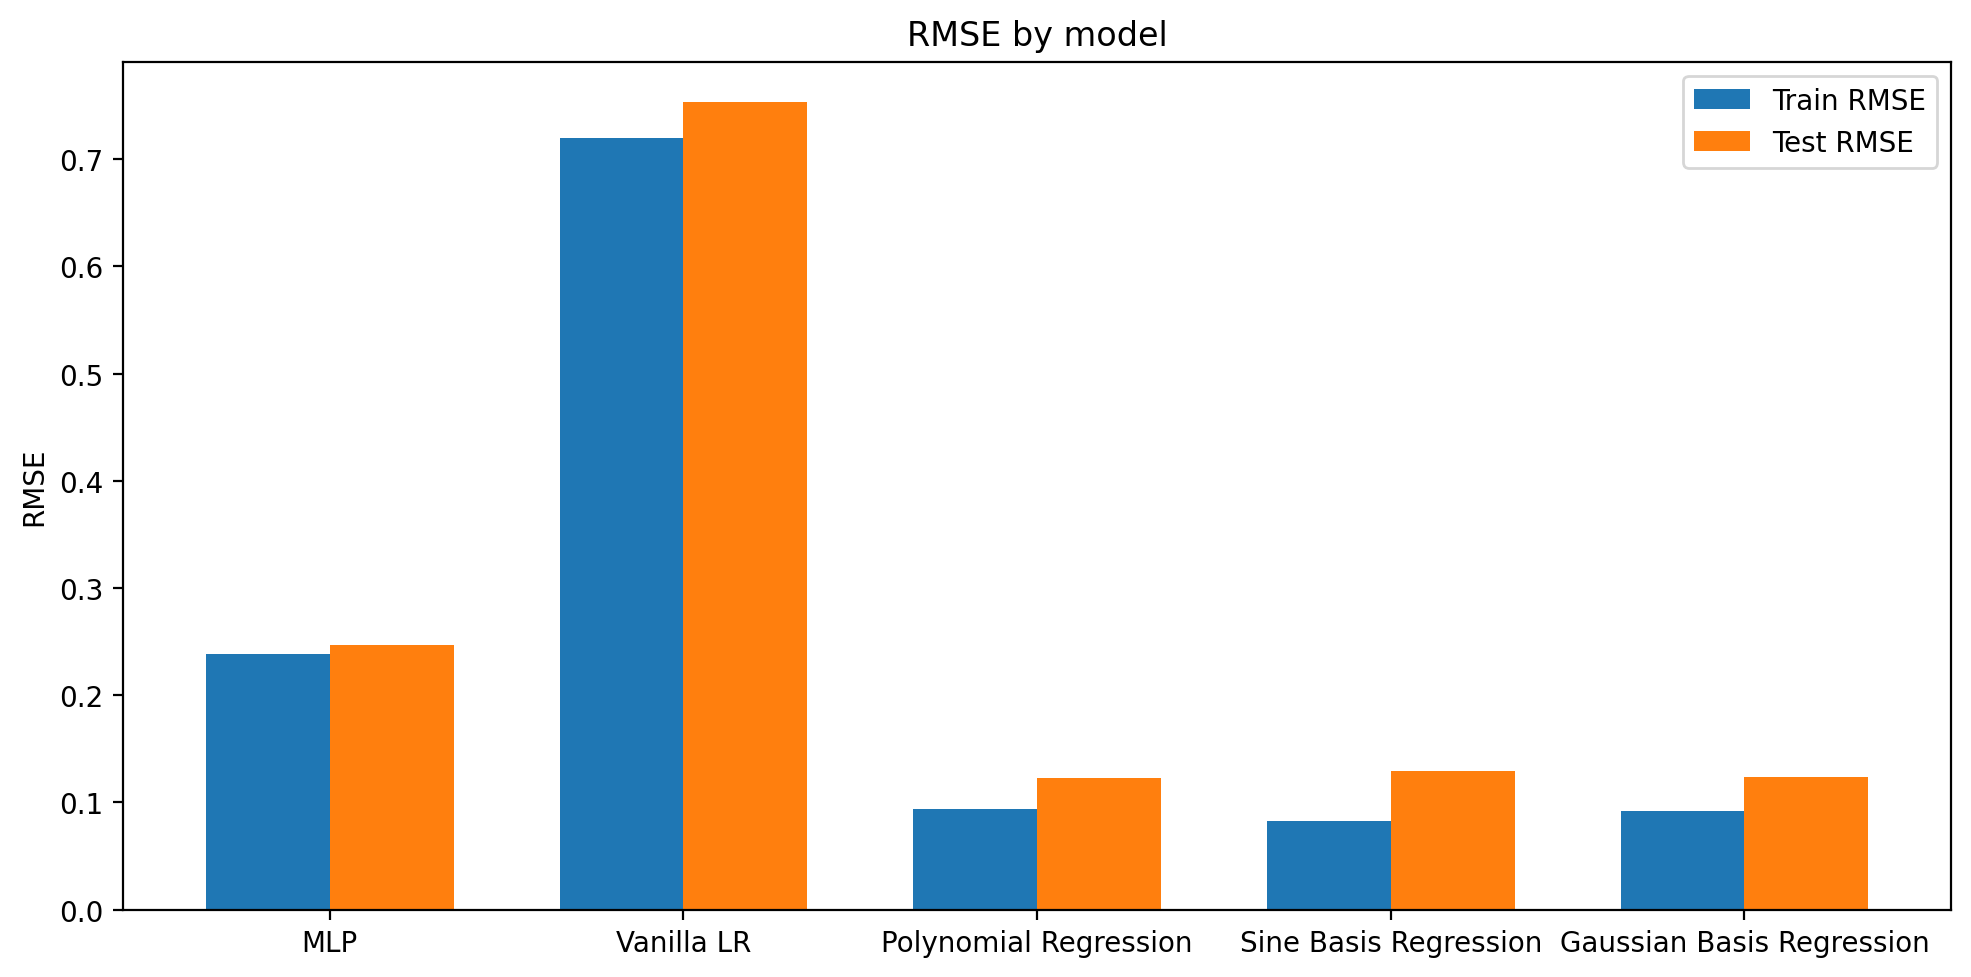

In [83]:
# create a bar plot of train and test RMSE

train_rmse = [rmse_dict[key][0] for key in rmse_dict.keys()]
test_rmse = [rmse_dict[key][1] for key in rmse_dict.keys()]
labels = [key for key in rmse_dict.keys()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, train_rmse, width, label='Train RMSE')
rects2 = ax.bar(x + width/2, test_rmse, width, label='Test RMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

# Dataset 2: CO2 Dataset

In [84]:
df

200 rows × 2 columns

In [85]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

In [ ]:
df

200 rows × 2 columns

In [ ]:
df.average.plot()

In [ ]:
train_cutoff = 2000
train = df[df.year < train_cutoff]
test = df[df.year >= train_cutoff]
df.average.plot()

train.average.plot(color='blue')
test.average.plot(color='orange')

len(train), len(test)

In [ ]:
months_from_start = range(len(df))
months_from_start = np.array(months_from_start).reshape(-1, 1)

In [ ]:
# use sk-learn for MLP

mlp_model = MLPRegressor(hidden_layer_sizes=[512, 512, 512, 512, 512], max_iter = 5000)
mlp_model.fit(months_from_start[:len(train)], train.average.values)

In [ ]:
yhat_train = mlp_model.predict(months_from_start[:len(train)])
yhat_test = mlp_model.predict(months_from_start[len(train):])

yhat_train = pd.Series(yhat_train, index=train.index)
yhat_test = pd.Series(yhat_test, index=test.index)

df.average.plot()
yhat_train.plot()
yhat_test.plot()

# Train error
train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
# normalize data

train_scaled = (train - train.mean()) / train.std()
test_scaled = (test - test.mean()) / test.std()
months_from_start_scaled = (months_from_start - months_from_start.mean()) / months_from_start.std()

# train_scaled = (train - train.mean()) / train.std()
# test_scaled = (test - test.mean()) / test.std()
# months_from_start_scaled = (months_from_start - months_from_start.mean()) / months_from_start.std()

mlp_model = MLPRegressor(hidden_layer_sizes=512, max_iter = 1000)
mlp_model.fit(months_from_start_scaled[:len(train)], train_scaled.average.values)

yhat_train = mlp_model.predict(months_from_start_scaled[:len(train)])
yhat_test = mlp_model.predict(months_from_start_scaled[len(train):])

yhat_train_scaled = pd.Series(yhat_train, index=train.index)
yhat_test_scaled = pd.Series(yhat_test, index=test.index)

yhat_train = yhat_train_scaled * train.std() + train.mean()
# yhat_test = yhat_test_scaled * test.std() + test.mean()


df.average.plot()
yhat_train.plot()
yhat_test.plot()

# Train error
train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

### Model 2: Vanilla Linear Regression

In [ ]:
lr1 = LinearRegression()
lr1.fit(months_from_start[:len(train)], train.average.values)
yhat1_test = lr1.predict(months_from_start[len(train):])
yhat1_train = lr1.predict(months_from_start[:len(train)])

yhat_train = pd.Series(yhat1_train, index=train.index)
yhat_test = pd.Series(yhat1_test, index=test.index)

df.average.plot()
yhat_train.plot()
yhat_test.plot()

# Train error
train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

### Model 3: Polynomial regression with degree d

In [ ]:
def poly_regression(d, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    pf = PolynomialFeatures(degree=d)
    X_train = pf.fit_transform(months_from_start[:len(train)])
    X_test = pf.fit_transform(months_from_start[len(train):])
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    df.average.plot()
    yhat_train.plot()
    yhat_test.plot()
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
poly_regression(2, train, test)

### Model 4: Linear Regression with sine and cosine basis functions

In [ ]:
### Adding sine and cosine terms
def sine_cosine_features(X, n):
    """
    X: array of shape (n_samples, 1)
    n: number of sine and cosine features to add
    """
    for i in range(1, n+1):
        X = np.hstack([X, np.sin(i*X), np.cos(i*X)])
    return X

In [ ]:
X = np.linspace(-1, 1, 100).reshape(-1, 1)

In [ ]:
_ = plt.plot(X, sine_cosine_features(X, 0))

### Model 5: Gaussian basis functions

### Model 6: Linear Regression with polynomial and sine/cosine basis functions

In [ ]:
def poly_sine_cosine_regression(n, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    
    X_train = sine_cosine_features(months_from_start[:len(train)], n)
    
    X_test = sine_cosine_features(months_from_start[len(train):], n)
    print(X_train.shape, X_test.shape)
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    
    yhat_train.plot(alpha=0.2, lw=4)
    yhat_test.plot(alpha=0.2, lw=4)
    df.average.plot(color='k', lw=1)
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
poly_sine_cosine_regression(6, train, test)

### Model 7: Random Fourier Features

In [ ]:
def rff_featurise(X, n_components=100):
    # Random Fourier Features
    # https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html
    from sklearn.kernel_approximation import RBFSampler
    rbf_feature = RBFSampler(gamma=1, n_components=n_components, random_state=1)
    X_features = rbf_feature.fit_transform(X)
    return X_features

In [ ]:
def poly_rff_regression(n, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    
    X_train = rff_featurise(months_from_start[:len(train)], n)
    
    X_test = rff_featurise(months_from_start[len(train):], n)
    print(X_train.shape, X_test.shape)
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    
    yhat_train.plot(alpha=0.2, lw=4)
    yhat_test.plot(alpha=0.2, lw=4)
    df.average.plot(color='k', lw=1)
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
poly_rff_regression(440, train, test)